In [2]:
import sys
print(sys.executable)
print(sys.version)


c:\Users\User\Downloads\ProjetoFinalIA\.venv\Scripts\python.exe
3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


In [3]:
from pycaret.regression import setup, compare_models
from pycaret.classification import setup as clf_setup

import pycaret
pycaret.__version__


'3.3.2'

In [4]:
# %% [markdown]
# # Projeto: Impacto da IA em Empregos até 2030
# Notebook para rodar no Jupyter do VS Code (Python 3.10 + PyCaret)

# %%
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB

import ipywidgets as widgets
from IPython.display import display

# Importar PyCaret modularmente para evitar conflito de nomes
from pycaret import regression as pyreg
from pycaret import classification as pyclf

sns.set(style="whitegrid")
pd.options.display.float_format = "{:,.3f}".format


In [5]:
# %%
# Carregar dataset (certifique-se de que o CSV está na mesma pasta do notebook)
df = pd.read_csv("AI_Impact_on_Jobs_2030.csv")

print("Formato do dataset:", df.shape)
df.head()


Formato do dataset: (3000, 18)


Job_Title  Average_Salary  Years_Experience Education_Level  \
0       Security Guard           45795                28        Master's   
1   Research Scientist          133355                20             PhD   
2  Construction Worker          146216                 2     High School   
3    Software Engineer          136530                13             PhD   
4    Financial Analyst           70397                22     High School   

   AI_Exposure_Index  Tech_Growth_Factor  Automation_Probability_2030  \
0              0.180               1.280                        0.850   
1              0.620               1.110                        0.050   
2              0.860               1.180                        0.810   
3              0.390               0.680                        0.600   
4              0.520               1.460                        0.640   

  Risk_Category  Skill_1  Skill_2  Skill_3  Skill_4  Skill_5  Skill_6  \
0          High    0.450    0.100    0.460    0.330    0.140    0.650   
1           Low    0.020    0.520    0.400    0.050    0.970    0.230   
2          High    0.010    0.940    0.560    0.390    0.020    0.230   
3        Medium    0.430    0.210    0.570    0.030    0.840    0.450   
4        Medium    0.750    0.540    0.590    0.970    0.610    0.280   

   Skill_7  Skill_8  Skill_9  Skill_10  
0    0.060    0.720    0.940     0.000  
1    0.090    0.620    0.380     0.980  
2    0.240    0.680    0.610     0.830  
3    0.400    0.930    0.730     0.330  
4    0.300    0.170    0.020     0.420

In [6]:
# %%
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Job_Title                    3000 non-null   object 
 1   Average_Salary               3000 non-null   int64  
 2   Years_Experience             3000 non-null   int64  
 3   Education_Level              3000 non-null   object 
 4   AI_Exposure_Index            3000 non-null   float64
 5   Tech_Growth_Factor           3000 non-null   float64
 6   Automation_Probability_2030  3000 non-null   float64
 7   Risk_Category                3000 non-null   object 
 8   Skill_1                      3000 non-null   float64
 9   Skill_2                      3000 non-null   float64
 10  Skill_3                      3000 non-null   float64
 11  Skill_4                      3000 non-null   float64
 12  Skill_5                      3000 non-null   float64
 13  Skill_6           

In [7]:
# %%
df.describe().T


count       mean        std        min  \
Average_Salary              3,000.000 89,372.279 34,608.089 30,030.000   
Years_Experience            3,000.000     14.678      8.740      0.000   
AI_Exposure_Index           3,000.000      0.501      0.284      0.000   
Tech_Growth_Factor          3,000.000      0.995      0.288      0.500   
Automation_Probability_2030 3,000.000      0.502      0.248      0.050   
Skill_1                     3,000.000      0.497      0.288      0.000   
Skill_2                     3,000.000      0.497      0.288      0.000   
Skill_3                     3,000.000      0.499      0.288      0.000   
Skill_4                     3,000.000      0.504      0.287      0.000   
Skill_5                     3,000.000      0.490      0.286      0.000   
Skill_6                     3,000.000      0.500      0.286      0.000   
Skill_7                     3,000.000      0.499      0.288      0.000   
Skill_8                     3,000.000      0.503      0.290      0.000   
Skill_9                     3,000.000      0.501      0.286      0.000   
Skill_10                    3,000.000      0.494      0.286      0.000   

                                   25%        50%         75%         max  
Average_Salary              58,640.000 89,318.000 119,086.500 149,798.000  
Years_Experience                 7.000     15.000      22.000      29.000  
AI_Exposure_Index                0.260      0.500       0.740       1.000  
Tech_Growth_Factor               0.740      1.000       1.240       1.500  
Automation_Probability_2030      0.310      0.500       0.700       0.950  
Skill_1                          0.240      0.505       0.740       1.000  
Skill_2                          0.250      0.500       0.740       1.000  
Skill_3                          0.250      0.500       0.750       1.000  
Skill_4                          0.260      0.510       0.750       1.000  
Skill_5                          0.240      0.490       0.730       1.000  
Skill_6                          0.260      0.500       0.740       1.000  
Skill_7                          0.250      0.490       0.750       1.000  
Skill_8                          0.250      0.500       0.750       1.000  
Skill_9                          0.260      0.500       0.740       1.000  
Skill_10                         0.250      0.490       0.740       1.000

In [8]:
# %%
df.isna().sum()


Job_Title                      0
Average_Salary                 0
Years_Experience               0
Education_Level                0
AI_Exposure_Index              0
Tech_Growth_Factor             0
Automation_Probability_2030    0
Risk_Category                  0
Skill_1                        0
Skill_2                        0
Skill_3                        0
Skill_4                        0
Skill_5                        0
Skill_6                        0
Skill_7                        0
Skill_8                        0
Skill_9                        0
Skill_10                       0
dtype: int64

In [9]:
# %%
# Identificar colunas numéricas e categóricas
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)


Numéricas: ['Average_Salary', 'Years_Experience', 'AI_Exposure_Index', 'Tech_Growth_Factor', 'Automation_Probability_2030', 'Skill_1', 'Skill_2', 'Skill_3', 'Skill_4', 'Skill_5', 'Skill_6', 'Skill_7', 'Skill_8', 'Skill_9', 'Skill_10']
Categóricas: ['Job_Title', 'Education_Level', 'Risk_Category']


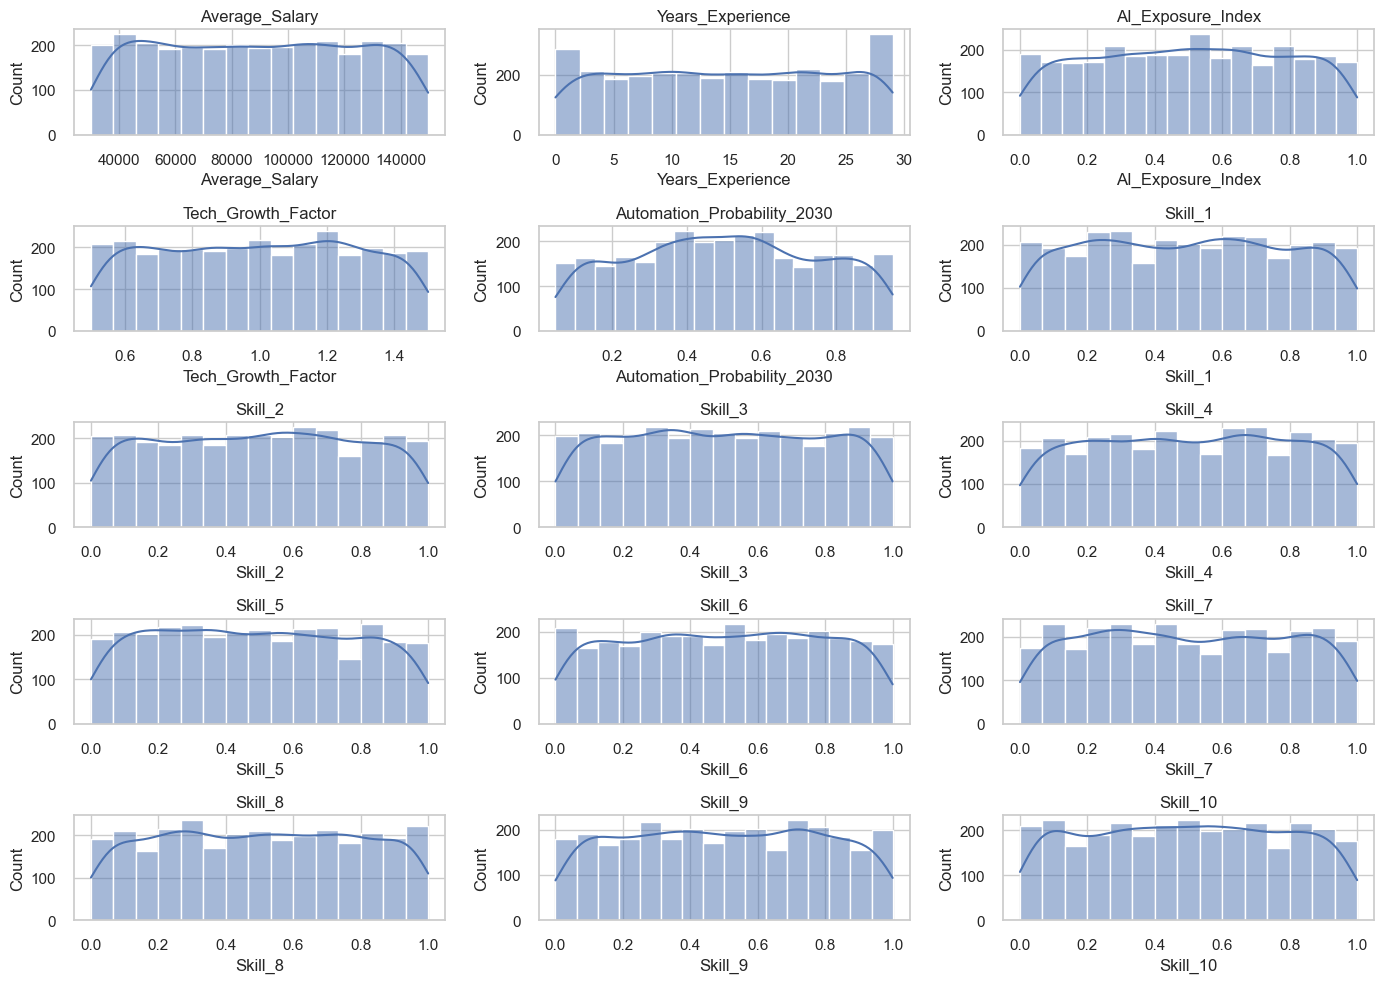

In [10]:
# %%
# Histogramas das variáveis numéricas
plt.figure(figsize=(14, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(math.ceil(len(num_cols) / 3), 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


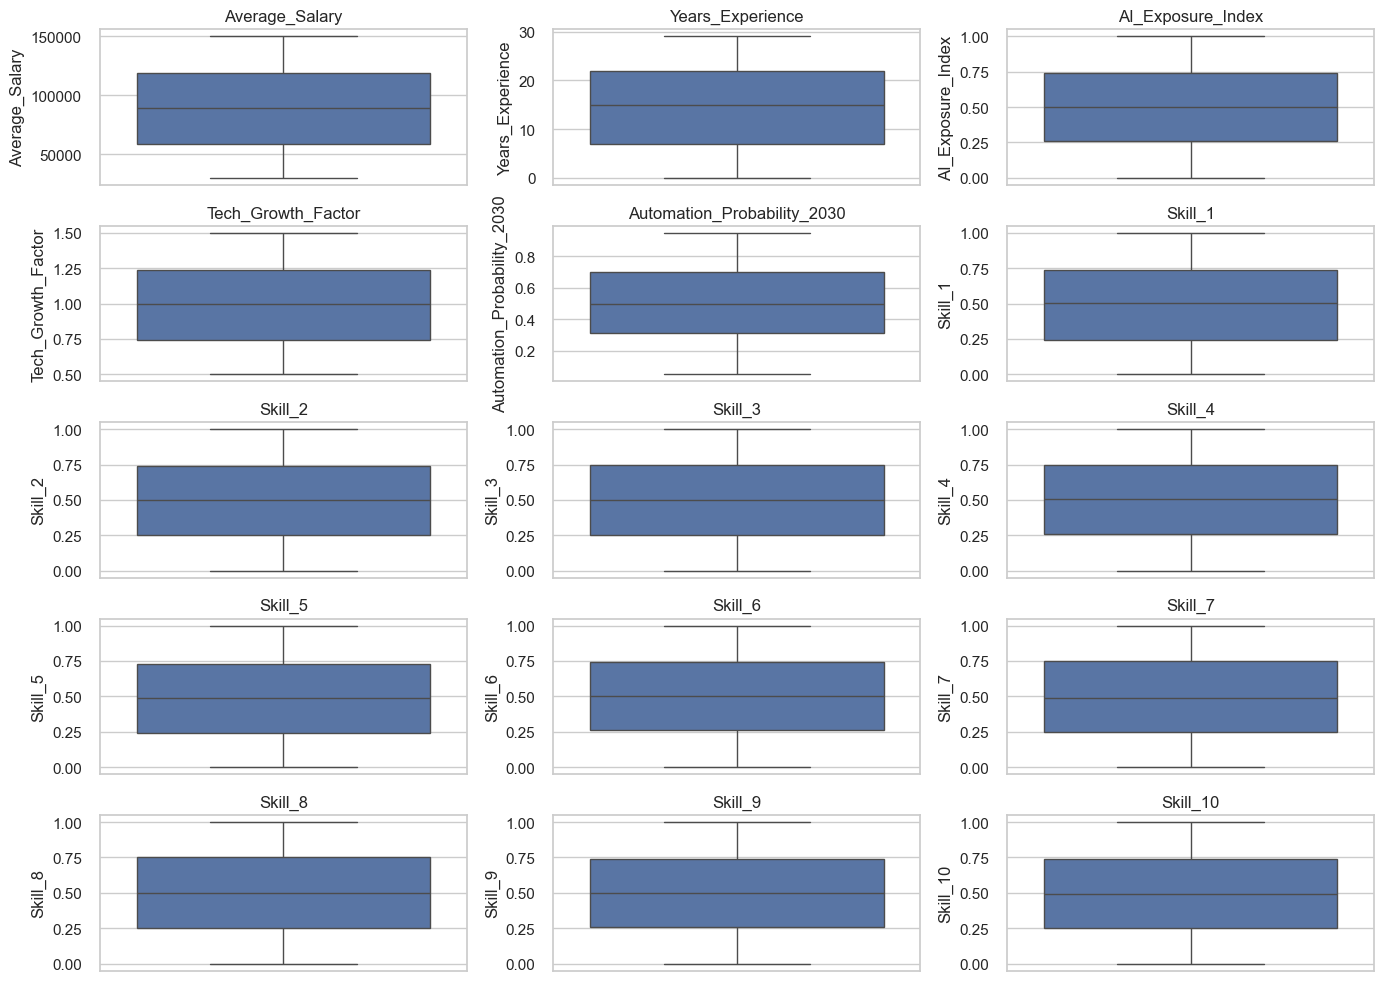

In [11]:
# %%
# Boxplots para visualizar outliers nas numéricas
plt.figure(figsize=(14, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(math.ceil(len(num_cols) / 3), 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


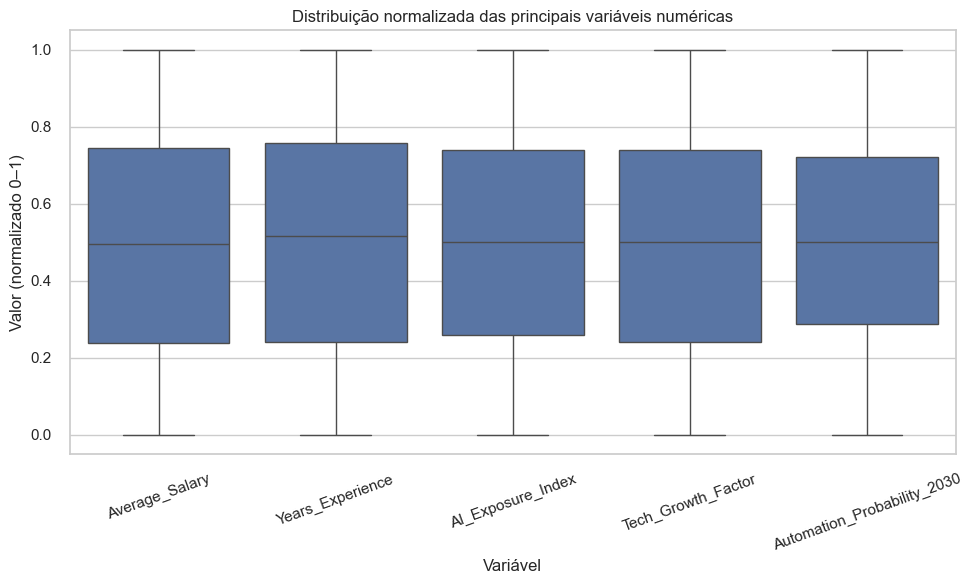

In [12]:
# Boxplots para visualizar outliers nas numéricas

from sklearn.preprocessing import MinMaxScaler

# Selecionar variáveis principais
num_main = [
    "Average_Salary",
    "Years_Experience",
    "AI_Exposure_Index",
    "Tech_Growth_Factor",
    "Automation_Probability_2030"
]

# Escalar (0–1)
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[num_main]), columns=num_main)

# Transformar para formato long (melt)
df_scaled_melt = df_scaled.melt(var_name="Variável", value_name="Valor_Normalizado")

plt.figure(figsize=(10,6))
ax = sns.boxplot(
    data=df_scaled_melt,
    x="Variável",
    y="Valor_Normalizado"
)

ax.set_title("Distribuição normalizada das principais variáveis numéricas")
ax.set_xlabel("Variável")
ax.set_ylabel("Valor (normalizado 0–1)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


“Para comparar variáveis em escalas distintas (salário em milhares, experiência em anos e índices entre 0 e 1), foi aplicada normalização MinMax. Após o reescalonamento, observamos que todas as variáveis exibem distribuições distintas, com diferentes amplitudes e assimetrias, permitindo uma análise mais equilibrada do comportamento de cada variável.”

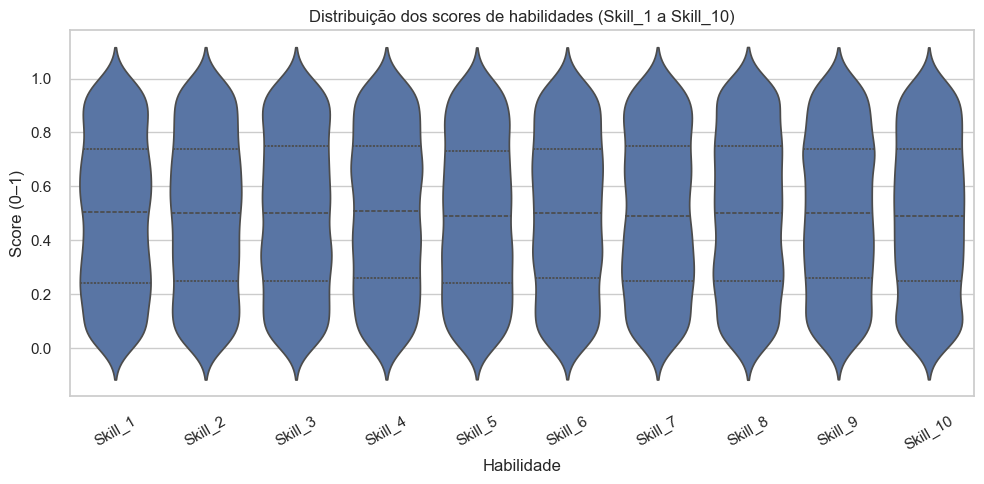

In [13]:
skill_cols = [c for c in df.columns if c.startswith("Skill_")]

df_skills = df[skill_cols].melt(var_name="Skill", value_name="Score")

plt.figure(figsize=(10,5))
ax = sns.violinplot(
    data=df_skills,
    x="Skill",
    y="Score",
    inner="quartile"
)

ax.set_title("Distribuição dos scores de habilidades (Skill_1 a Skill_10)")
ax.set_xlabel("Habilidade")
ax.set_ylabel("Score (0–1)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


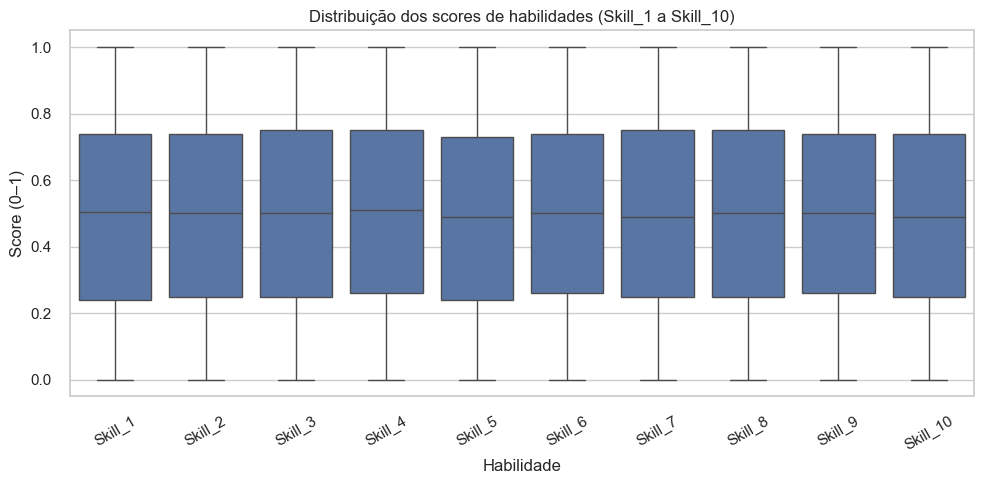

In [14]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(
    data=df_skills,
    x="Skill",
    y="Score"
)
ax.set_title("Distribuição dos scores de habilidades (Skill_1 a Skill_10)")
ax.set_xlabel("Habilidade")
ax.set_ylabel("Score (0–1)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


“Inicialmente fizemos boxplots para todas as variáveis numéricas, mas o gráfico ficou muito carregado e pouco informativo, principalmente porque as variáveis de habilidades (Skill_1 a Skill_10) têm distribuições muito parecidas.

Por isso, separamos as variáveis principais em um boxplot específico e as habilidades em outro gráfico agregado.

Observamos que salário e experiência têm faixas de variação bem maiores, enquanto os scores de habilidades se concentram entre 0 e 1 com distribuições semelhantes entre si, o que reforça o caráter sintético do dataset.”

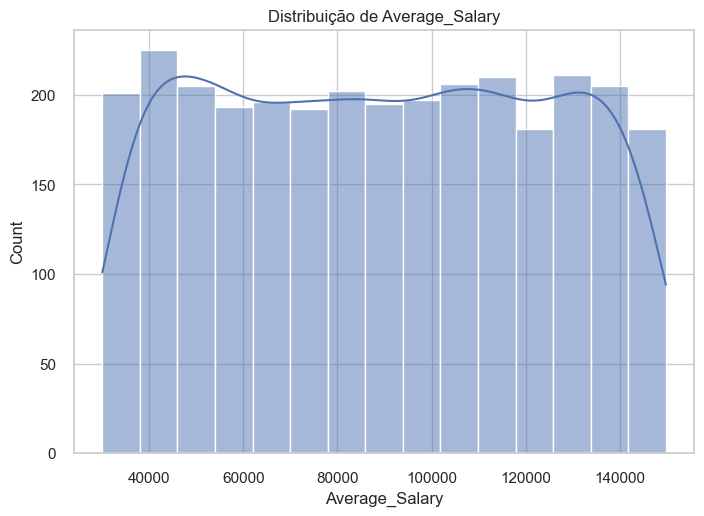

In [15]:
# %%
# Distribuição do salário médio
sns.histplot(df["Average_Salary"], kde=True)
plt.title("Distribuição de Average_Salary")
plt.show()


In [16]:

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 13
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11


plt.figure(figsize=(9,6))




<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

In [18]:
df["Exp_Range"] = pd.cut(
    df["Years_Experience"],
    bins=[0, 5, 10, 15, 20, 25, 30],
    labels=["0–5", "5–10", "10–15", "15–20", "20–25", "25–30"],
    include_lowest=True
)

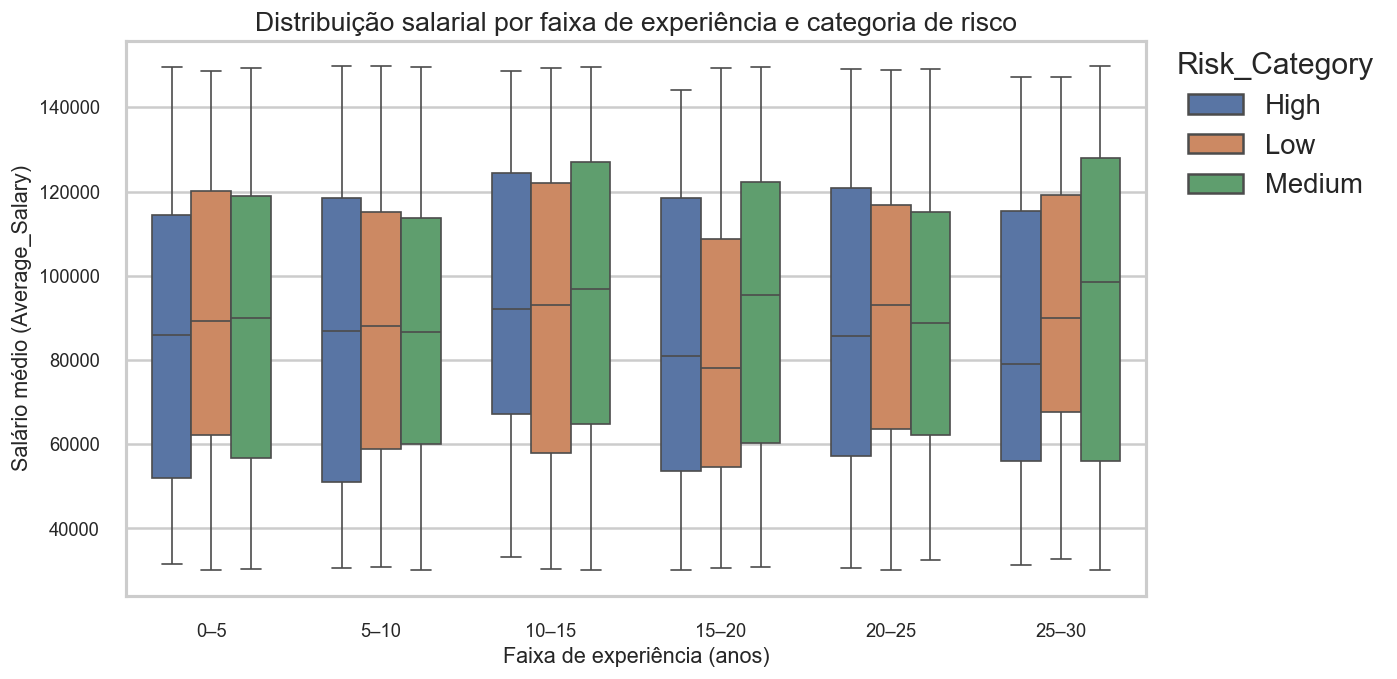

In [19]:
plt.figure(figsize=(12,6))

ax = sns.boxplot(
    data=df,
    x="Exp_Range",
    y="Average_Salary",
    hue="Risk_Category",
    width=0.7
)

ax.set_xlabel("Faixa de experiência (anos)")
ax.set_ylabel("Salário médio (Average_Salary)")
ax.set_title("Distribuição salarial por faixa de experiência e categoria de risco")

# Legenda fora do gráfico (fica mais clean)
ax.legend(
    title="Risk_Category",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.
)

plt.tight_layout()
plt.show()


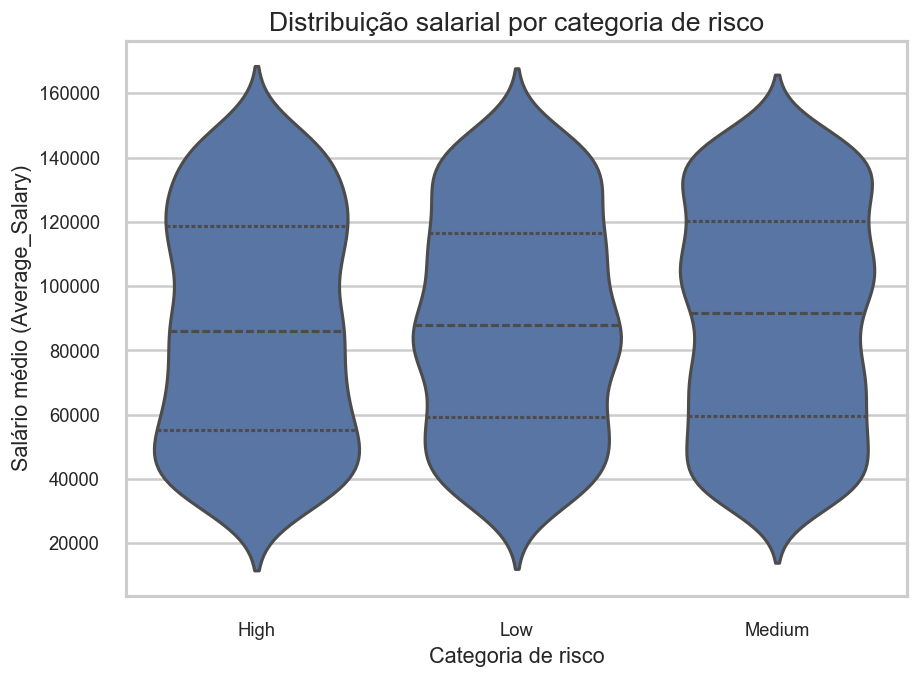

In [20]:
plt.figure(figsize=(8,6))

ax = sns.violinplot(
    data=df,
    x="Risk_Category",
    y="Average_Salary",
    inner="quartile"
)

ax.set_xlabel("Categoria de risco")
ax.set_ylabel("Salário médio (Average_Salary)")
ax.set_title("Distribuição salarial por categoria de risco")
plt.tight_layout()
plt.show()


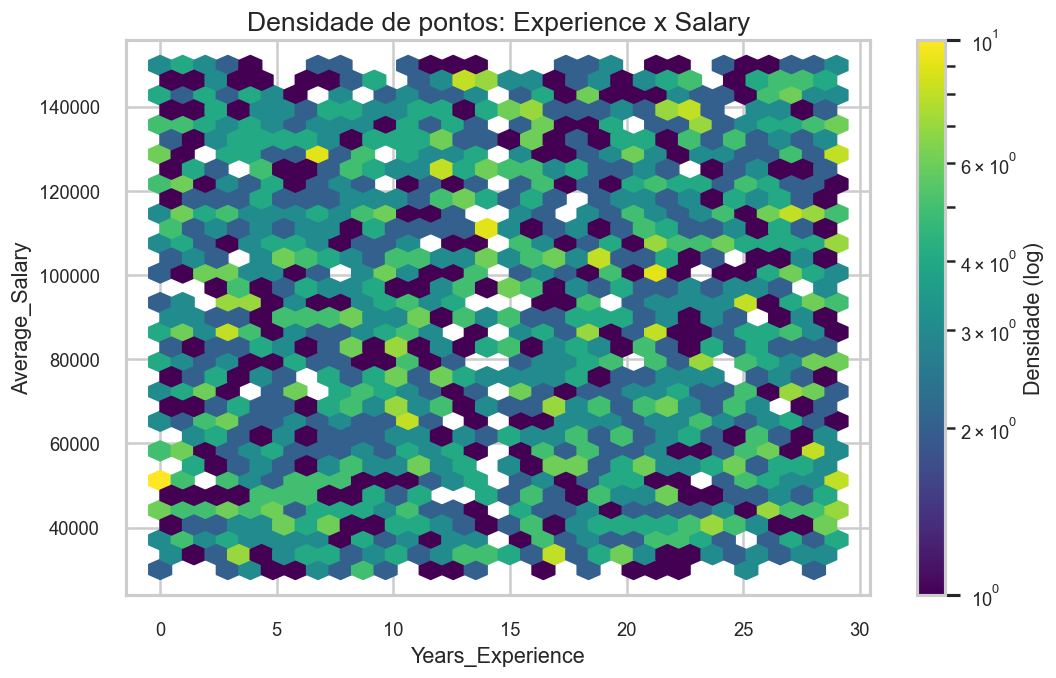

In [21]:
plt.figure(figsize=(10,6))
plt.hexbin(
    df["Years_Experience"],
    df["Average_Salary"],
    gridsize=30,
    cmap="viridis",
    bins="log"
)
plt.colorbar(label="Densidade (log)")
plt.xlabel("Years_Experience")
plt.ylabel("Average_Salary")
plt.title("Densidade de pontos: Experience x Salary")
plt.show()


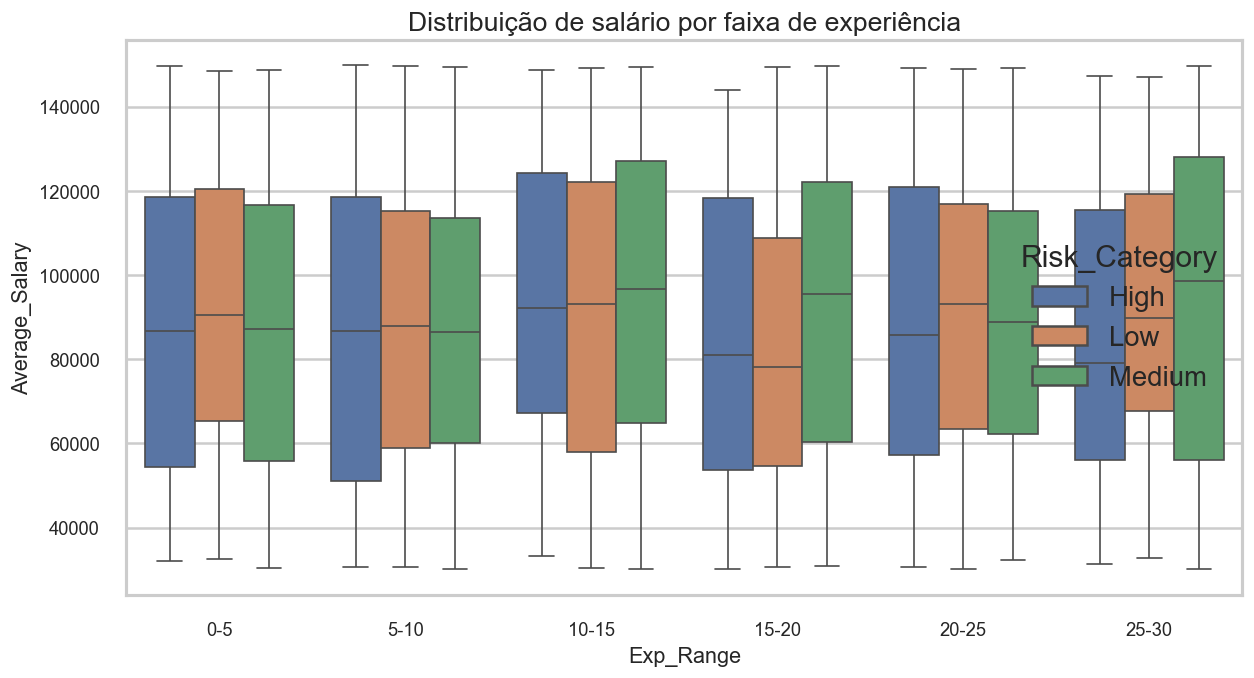

In [22]:
df["Exp_Range"] = pd.cut(df["Years_Experience"],
                         bins=[0,5,10,15,20,25,30],
                         labels=["0-5","5-10","10-15","15-20","20-25","25-30"])

plt.figure(figsize=(12,6))
sns.boxplot(
    data=df,
    x="Exp_Range",
    y="Average_Salary",
    hue="Risk_Category"
)
plt.title("Distribuição de salário por faixa de experiência")
plt.show()


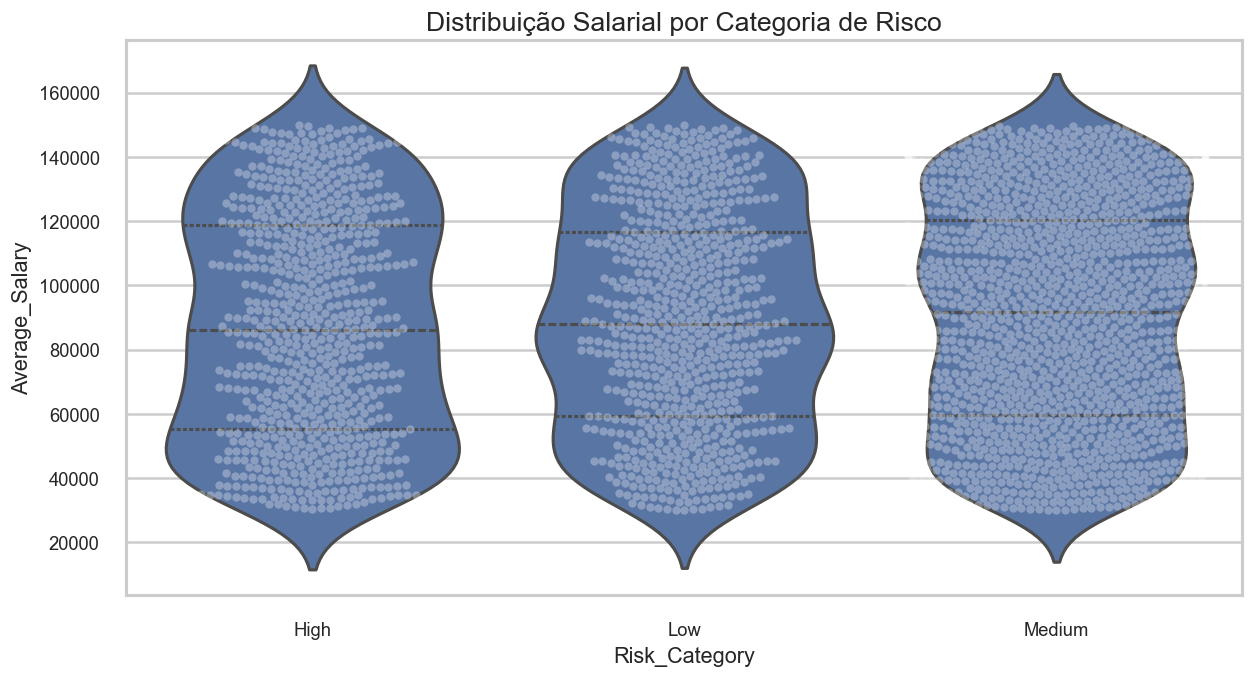

In [23]:
plt.figure(figsize=(12,6))
sns.violinplot(
    data=df,
    x="Risk_Category",
    y="Average_Salary",
    inner="quartile"
)
sns.swarmplot(
    data=df,
    x="Risk_Category",
    y="Average_Salary",
    color="white",
    alpha=0.3
)
plt.title("Distribuição Salarial por Categoria de Risco")
plt.show()


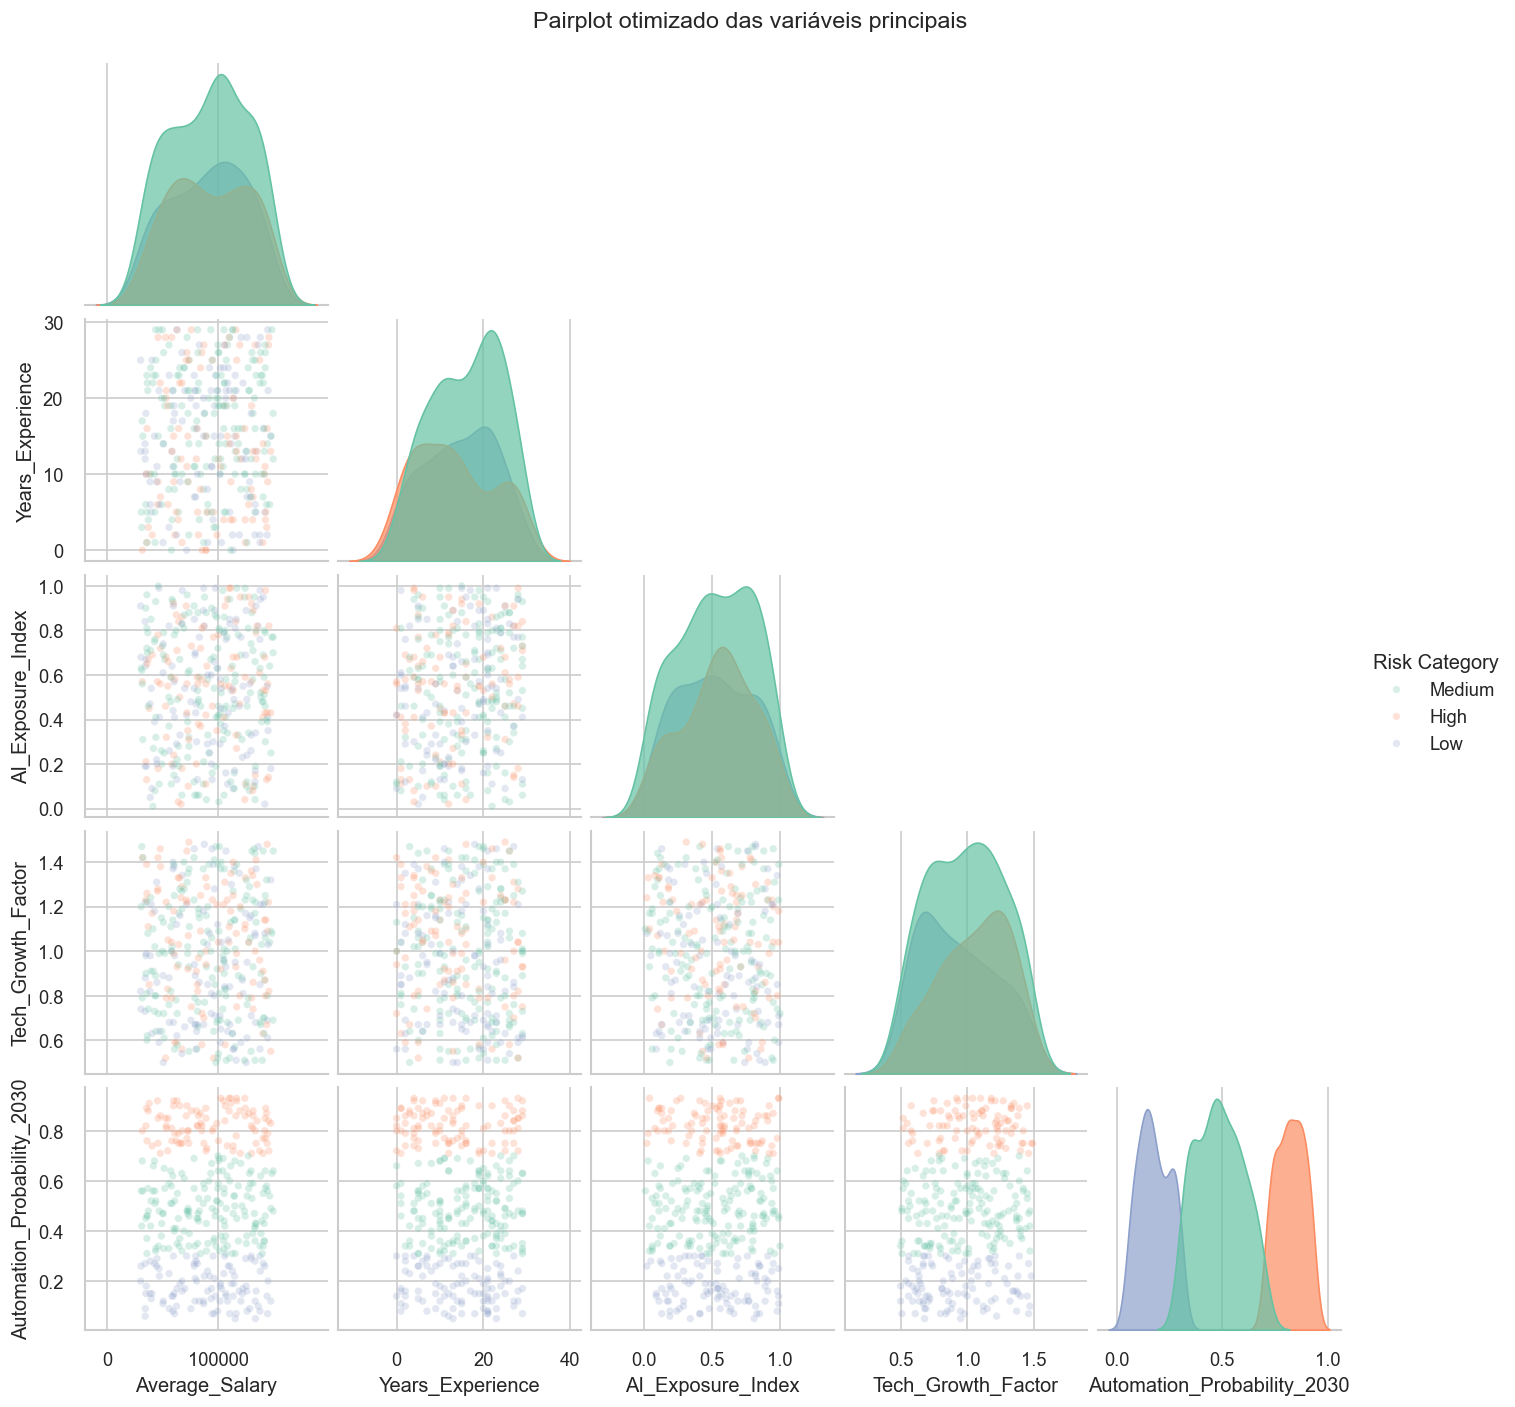

In [24]:


# Seleção de colunas principais
cols_pp = [
    "Average_Salary",
    "Years_Experience",
    "AI_Exposure_Index",
    "Tech_Growth_Factor",
    "Automation_Probability_2030",
    "Risk_Category"
]

# Amostragem para reduzir poluição visual
df_pp = df[cols_pp].sample(frac=0.12, random_state=42)  # ~12% dos dados

sns.set_theme(style="whitegrid")

# Pairplot otimizado
g = sns.pairplot(
    df_pp,
    hue="Risk_Category",
    corner=True,
    diag_kind="kde",
    plot_kws={"alpha": 0.25, "s": 20},    # pontos menores e mais transparentes
    diag_kws={"alpha": 0.7},
    palette="Set2",
    height=2.3
)

# Ajustes de tamanho e título
g.fig.suptitle("Pairplot otimizado das variáveis principais", y=1.02, fontsize=14)
g._legend.set_title("Risk Category")
plt.show()


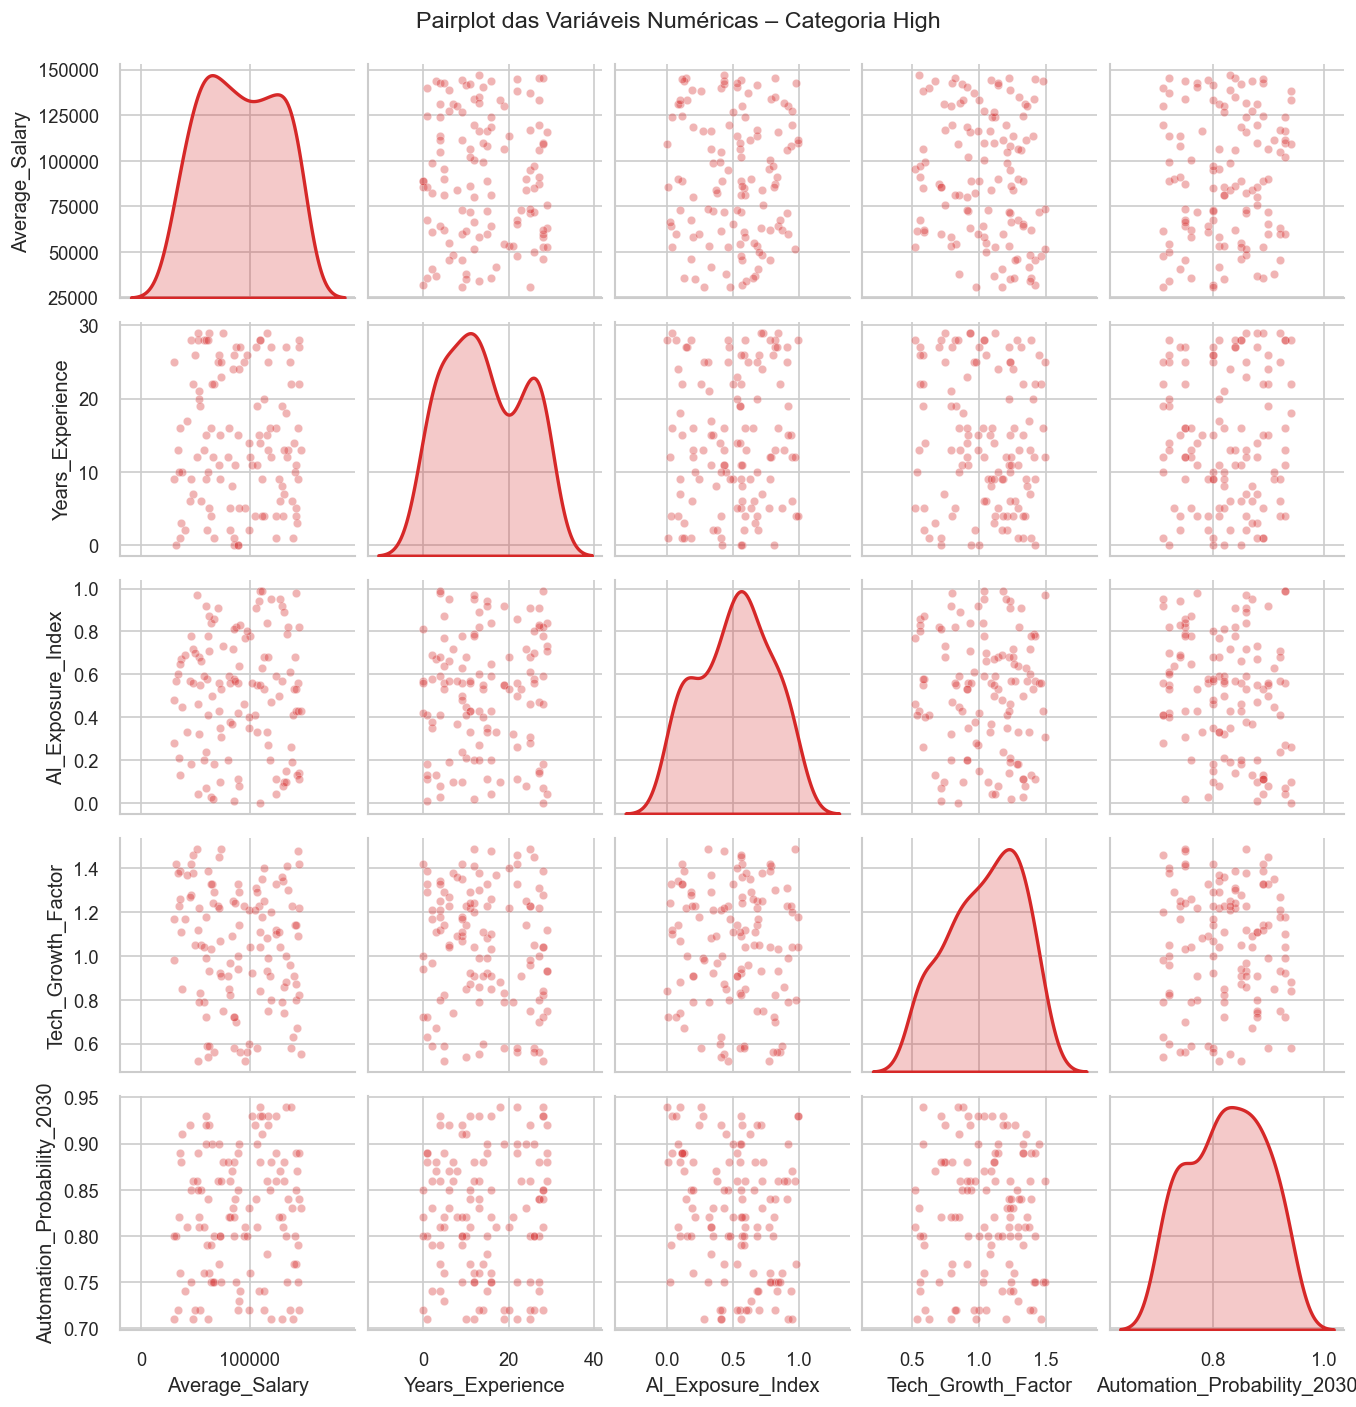

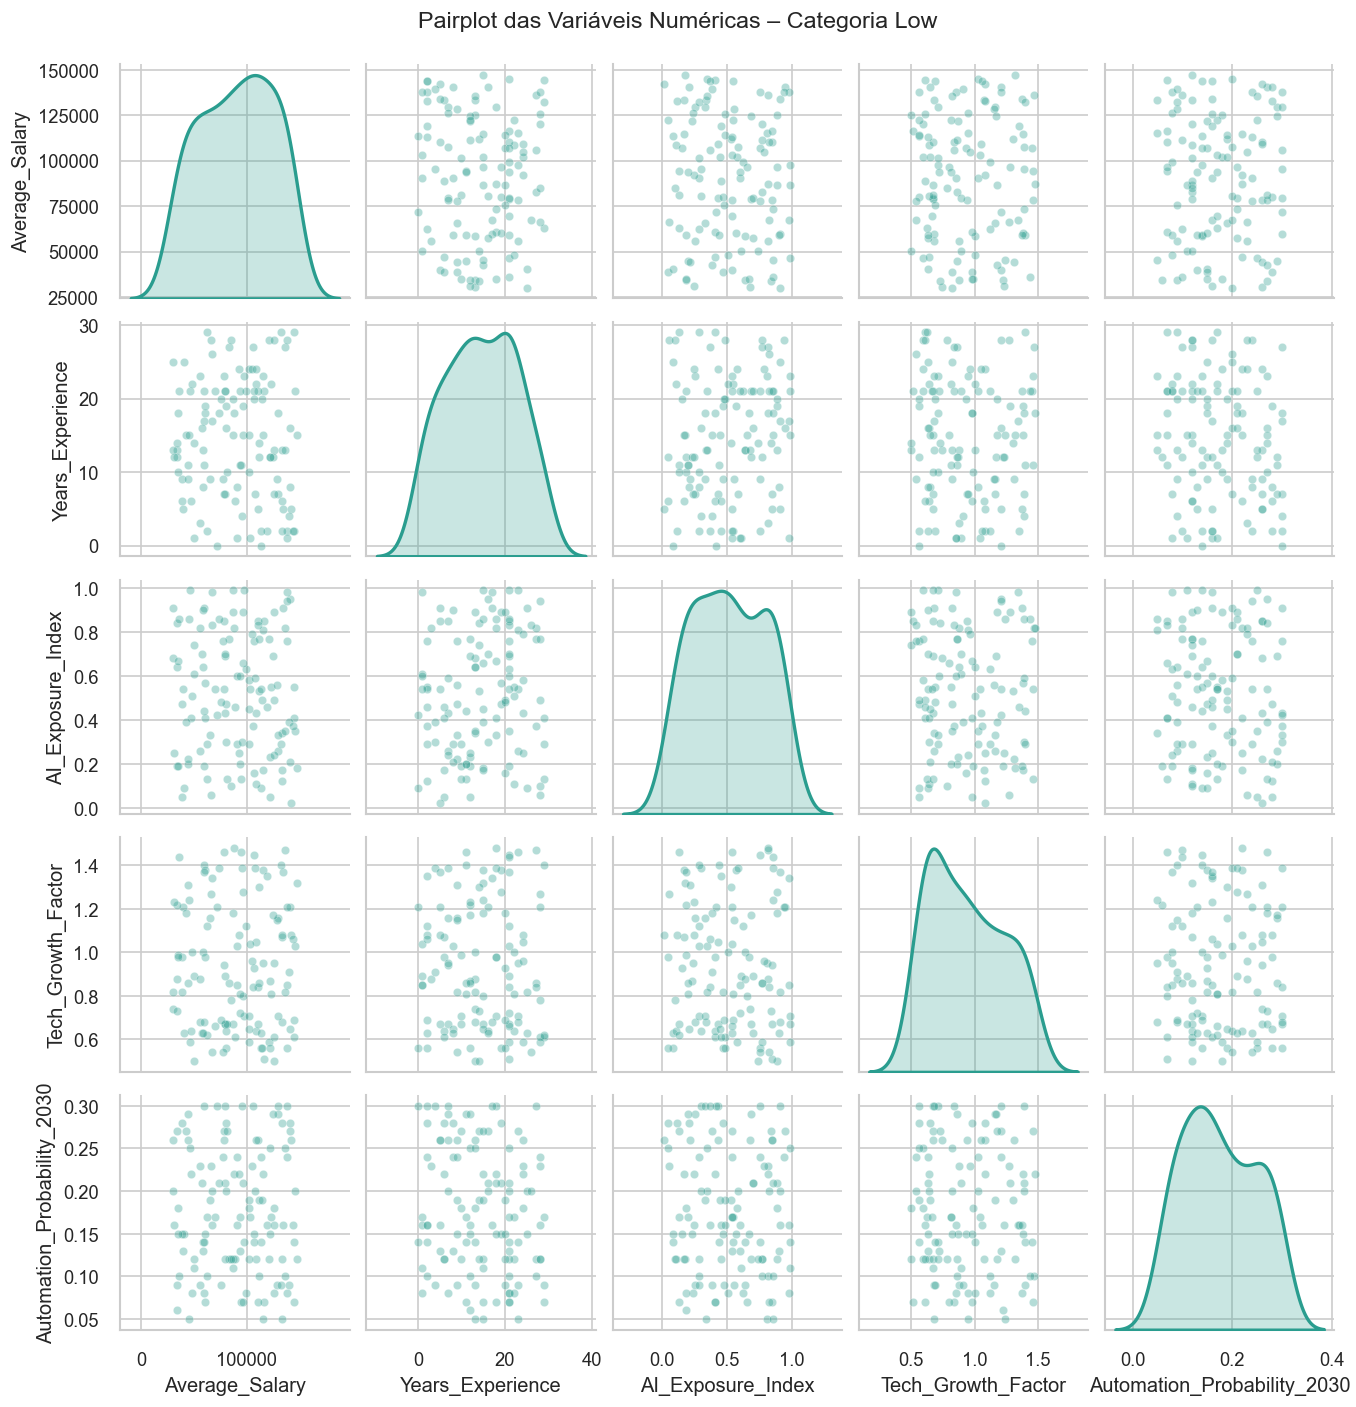

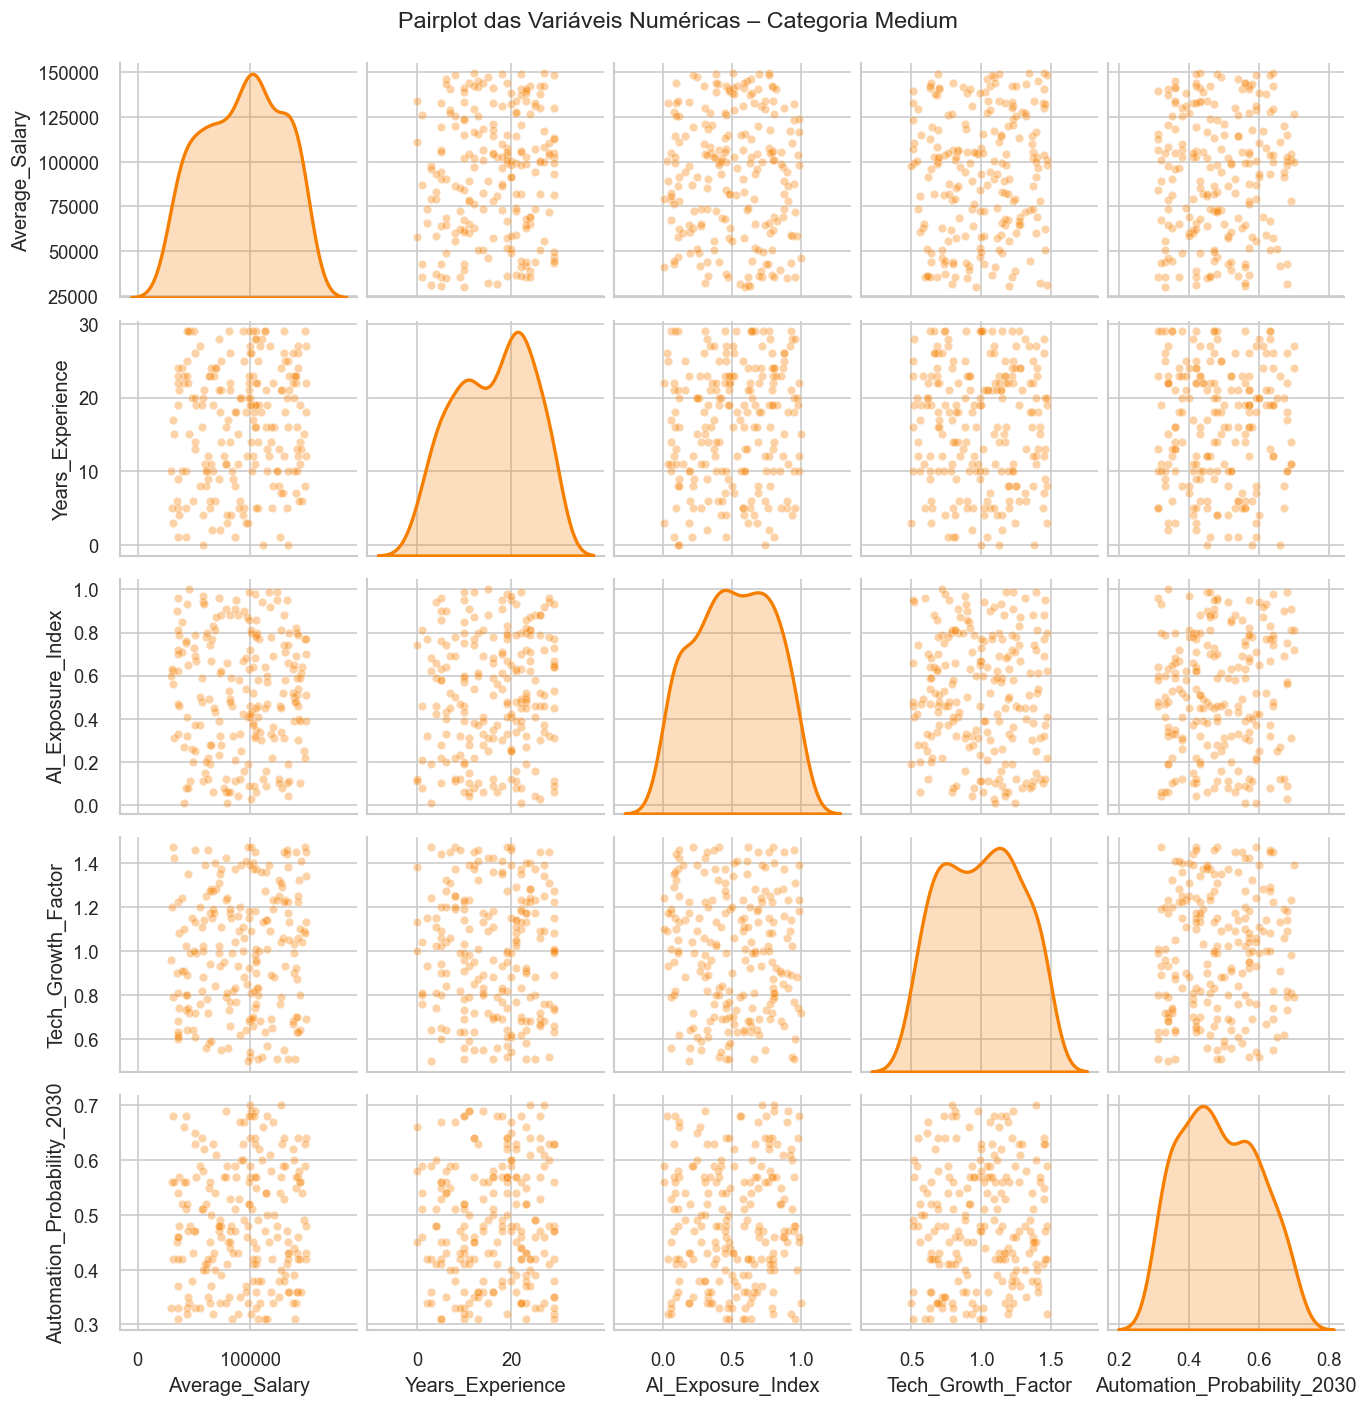

In [25]:

# Seleção das colunas numéricas principais
num_cols = [
    "Average_Salary",
    "Years_Experience",
    "AI_Exposure_Index",
    "Tech_Growth_Factor",
    "Automation_Probability_2030"
]

# Paleta personalizada para cada categoria
palette_dict = {
    "High":   "#D62828",  # vermelho
    "Medium": "#F77F00",  # laranja
    "Low":    "#2A9D8F"   # verde água
}

# Amostragem opcional para melhorar legibilidade
df_smpl = df[["Risk_Category"] + num_cols].sample(frac=0.15, random_state=42)

# Pairplot separado por categoria
for cat in df["Risk_Category"].unique():

    df_cat = df_smpl[df_smpl["Risk_Category"] == cat]

    g = sns.pairplot(
        df_cat[num_cols],
        diag_kind="kde",
        plot_kws={"alpha": 0.35, "s": 25, "color": palette_dict[cat]},
        diag_kws={"color": palette_dict[cat], "linewidth": 2},
        height=2.3
    )

    # Título do gráfico
    g.fig.suptitle(
        f"Pairplot das Variáveis Numéricas – Categoria {cat}",
        y=1.02,
        fontsize=14
    )

    plt.show()


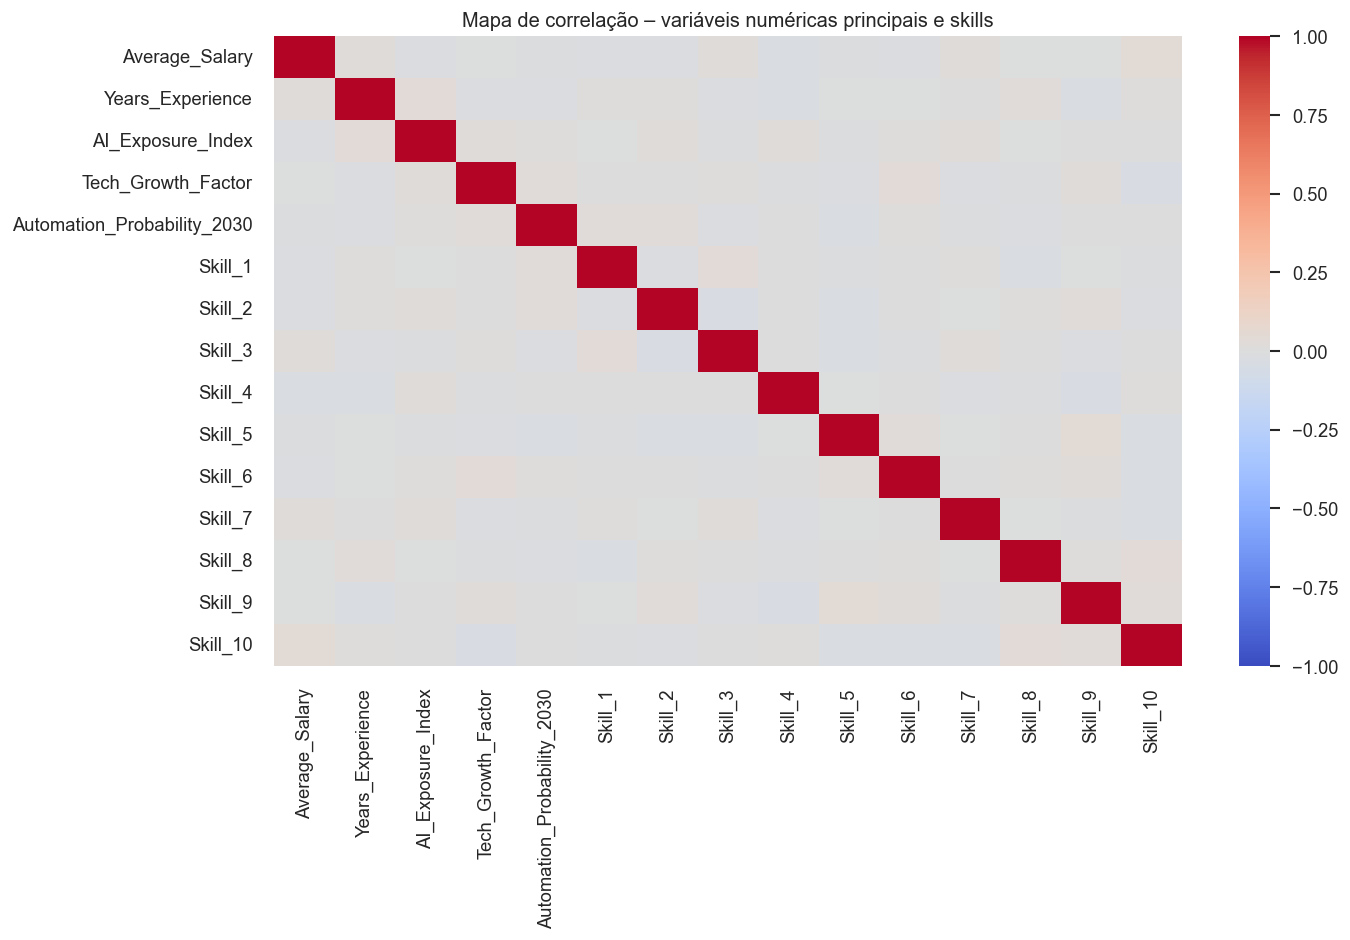

In [32]:
# Variáveis principais usadas no pairplot e no heatmap
num_cols_pair = [
    "Average_Salary",
    "Years_Experience",
    "AI_Exposure_Index",
    "Tech_Growth_Factor",
    "Automation_Probability_2030"
]

# Variáveis de skills
skill_cols = [c for c in df.columns if c.startswith("Skill_")]

# Colunas incluídas no heatmap
corr_cols = num_cols_pair + skill_cols

# Heatmap de correlação
corr = df[corr_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    annot=False
)
plt.title("Mapa de correlação – variáveis numéricas principais e skills")
plt.tight_layout()
plt.show()


In [35]:
from sklearn.model_selection import train_test_split

# Conjunto de features para regressão
features_reg = [
    "Years_Experience",
    "AI_Exposure_Index",
    "Tech_Growth_Factor",
    "Automation_Probability_2030"
] + [f"Skill_{i}" for i in range(1, 11)]

X_reg = df[features_reg]
y_reg = df["Average_Salary"]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg,
    test_size=0.2,
    random_state=42
)

# Conjunto de features para classificação (pode ser o mesmo, sem o alvo)
features_clf = features_reg.copy()
X_clf = df[features_clf]
y_clf = df["Risk_Category"]

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf,
    test_size=0.2,
    stratify=y_clf,
    random_state=42
)


In [36]:
# %%
# Distribuição de Risk_Category
df["Risk_Category"].value_counts()


Risk_Category
Medium    1521
High       740
Low        739
Name: count, dtype: int64

In [37]:
# %%
# Alvo de regressão
y_reg = df["Average_Salary"]

# Alvo de classificação
y_clf = df["Risk_Category"]

# Features: removendo alvos
X = df.drop(columns=["Average_Salary", "Risk_Category"])

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Features numéricas:", num_cols)
print("Features categóricas:", cat_cols)


Features numéricas: ['Years_Experience', 'AI_Exposure_Index', 'Tech_Growth_Factor', 'Automation_Probability_2030', 'Skill_1', 'Skill_2', 'Skill_3', 'Skill_4', 'Skill_5', 'Skill_6', 'Skill_7', 'Skill_8', 'Skill_9', 'Skill_10']
Features categóricas: ['Job_Title', 'Education_Level', 'Exp_Range']


In [38]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Regressão linear simples com statsmodels (toda a amostra)
ols_simple = smf.ols("Average_Salary ~ Years_Experience", data=df).fit()
print(ols_simple.summary())


                            OLS Regression Results                            
Dep. Variable:         Average_Salary   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9068
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.341
Time:                        17:20:13   Log-Likelihood:                -35611.
No. Observations:                3000   AIC:                         7.123e+04
Df Residuals:                    2998   BIC:                         7.124e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         8.836e+04   1235.185  

In [39]:
## Regressão linear múltipla (statsmodels)

formula_multi = """
Average_Salary ~ Years_Experience + AI_Exposure_Index
+ Tech_Growth_Factor + Automation_Probability_2030
"""

ols_multi = smf.ols(formula_multi, data=df).fit()
print(ols_multi.summary())


                            OLS Regression Results                            
Dep. Variable:         Average_Salary   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6740
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.610
Time:                        17:20:16   Log-Likelihood:                -35610.
No. Observations:                3000   AIC:                         7.123e+04
Df Residuals:                    2995   BIC:                         7.126e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [40]:
# Statsmodels com termo quadrático
##Regressão polinomial grau 2

ols_poly = smf.ols(
    "Average_Salary ~ Years_Experience + I(Years_Experience**2)",
    data=df
).fit()
print(ols_poly.summary())


                            OLS Regression Results                            
Dep. Variable:         Average_Salary   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4601
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.631
Time:                        17:20:18   Log-Likelihood:                -35611.
No. Observations:                3000   AIC:                         7.123e+04
Df Residuals:                    2997   BIC:                         7.125e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [41]:
# Pipeline sklearn para regressão polinomial (treino/teste)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

poly_pipeline = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("linreg", LinearRegression())
])

poly_pipeline.fit(X_train_reg[["Years_Experience"]], y_train_reg)
y_pred_poly = poly_pipeline.predict(X_test_reg[["Years_Experience"]])


In [42]:
# %%
# Split treino/teste (usando alvo de classificação para estratificar)
X_train, X_test, y_clf_train, y_clf_test = train_test_split(
    X,
    y_clf,
    test_size=0.2,
    random_state=42,
    stratify=y_clf
)

# Usar os mesmos índices para separar y_reg
y_reg_train = y_reg.loc[X_train.index]
y_reg_test = y_reg.loc[X_test.index]

X_train.shape, X_test.shape


((2400, 17), (600, 17))

In [43]:
# %%
# Pré-processamento: padronização numérica + one-hot categórica
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)


In [44]:
# %%
# Regressão linear simples: Average_Salary ~ Years_Experience
X_simple = df[["Years_Experience"]]
X_simple = sm.add_constant(X_simple)

ols_simple = sm.OLS(y_reg, X_simple).fit()
print(ols_simple.summary())


                            OLS Regression Results                            
Dep. Variable:         Average_Salary   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9068
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.341
Time:                        17:20:29   Log-Likelihood:                -35611.
No. Observations:                3000   AIC:                         7.123e+04
Df Residuals:                    2998   BIC:                         7.124e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8.836e+04   1235.185  

In [45]:
# %%
# Ajuste: verifique se essas colunas existem no seu dataset
features_ols = ["Years_Experience", "AI_Exposure_Index",
                "Tech_Growth_Factor", "Automation_Probability_2030"]

X_multi = df[features_ols]
X_multi = sm.add_constant(X_multi)

ols_multi = sm.OLS(y_reg, X_multi).fit()
print(ols_multi.summary())


                            OLS Regression Results                            
Dep. Variable:         Average_Salary   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6740
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.610
Time:                        17:20:30   Log-Likelihood:                -35610.
No. Observations:                3000   AIC:                         7.123e+04
Df Residuals:                    2995   BIC:                         7.126e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [46]:
# %%
# VIF (Variance Inflation Factor)
X_vif = df[features_ols].copy()
X_vif["const"] = 1

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]

vif_data


feature    VIF
0             Years_Experience  1.002
1            AI_Exposure_Index  1.002
2           Tech_Growth_Factor  1.001
3  Automation_Probability_2030  1.001
4                        const 22.566

In [47]:
# %%
# Baseline de regressão (LinearRegression com todas as features)
reg_baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

reg_baseline.fit(X_train, y_reg_train)
y_reg_pred = reg_baseline.predict(X_test)

mae = mean_absolute_error(y_reg_test, y_reg_pred)
rmse = mean_squared_error(y_reg_test, y_reg_pred, squared=False)
r2 = r2_score(y_reg_test, y_reg_pred)

print("Baseline Regressão (LinearRegression):")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)


Baseline Regressão (LinearRegression):
MAE: 30519.461666666666
RMSE: 35180.44559953251
R²: -0.016914399018803206


In [48]:
# %%
# Regressão polinomial (grau 3 para Years_Experience)
poly_features = ["Years_Experience"]

poly_preprocess = ColumnTransformer(
    transformers=[
        ("poly", PolynomialFeatures(degree=3, include_bias=False), poly_features),
        ("num", StandardScaler(), [c for c in num_cols if c not in poly_features]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

reg_poly = Pipeline(steps=[
    ("preprocess", poly_preprocess),
    ("model", LinearRegression())
])

reg_poly.fit(X_train, y_reg_train)
y_reg_poly_pred = reg_poly.predict(X_test)

mae_poly = mean_absolute_error(y_reg_test, y_reg_poly_pred)
rmse_poly = mean_squared_error(y_reg_test, y_reg_poly_pred, squared=False)
r2_poly = r2_score(y_reg_test, y_reg_poly_pred)

print("Regressão Polinomial (degree=3):")
print("MAE:", mae_poly)
print("RMSE:", rmse_poly)
print("R²:", r2_poly)


Regressão Polinomial (degree=3):
MAE: 30529.18386459394
RMSE: 35179.21269522295
R²: -0.016843124414143595


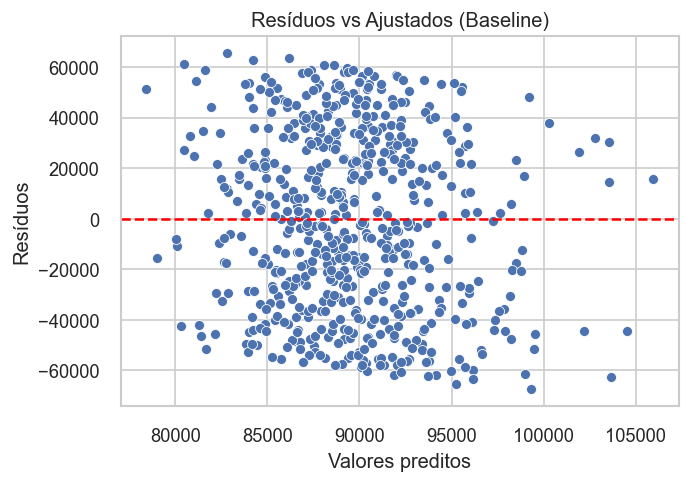

In [49]:
# %%
# Resíduos vs valores ajustados (baseline)
residuals = y_reg_test - y_reg_pred

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_reg_pred, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores preditos")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Ajustados (Baseline)")
plt.show()


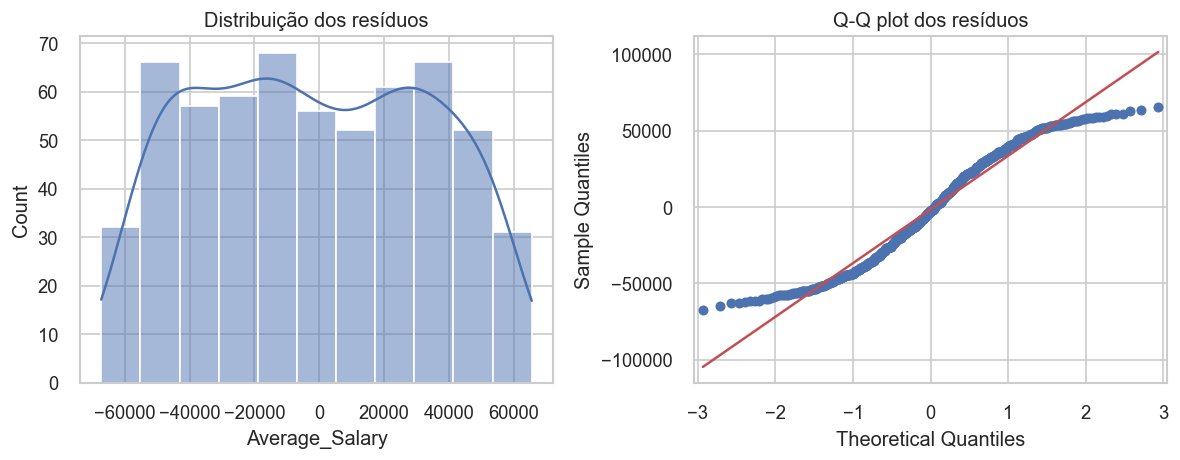

In [50]:
# %%
# Distribuição e Q-Q plot dos resíduos
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(residuals, kde=True, ax=axes[0])
axes[0].set_title("Distribuição dos resíduos")

sm.qqplot(residuals, line="s", ax=axes[1])
axes[1].set_title("Q-Q plot dos resíduos")

plt.tight_layout()
plt.show()


In [51]:
# %%
# Naive Bayes
clf_nb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GaussianNB())
])

clf_nb.fit(X_train, y_clf_train)
y_clf_nb_pred = clf_nb.predict(X_test)
y_clf_nb_proba = clf_nb.predict_proba(X_test)

print("Naive Bayes:")
print("Accuracy:", accuracy_score(y_clf_test, y_clf_nb_pred))
print("Precision macro:", precision_score(y_clf_test, y_clf_nb_pred, average="macro"))
print("Recall macro:", recall_score(y_clf_test, y_clf_nb_pred, average="macro"))
print("F1 macro:", f1_score(y_clf_test, y_clf_nb_pred, average="macro"))


Naive Bayes:
Accuracy: 0.9933333333333333
Precision macro: 0.9912280701754387
Recall macro: 0.9956140350877193
F1 macro: 0.9933480500367917


In [53]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

nb_clf = GaussianNB()
nb_clf.fit(X_train_clf, y_train_clf)

y_pred_nb = nb_clf.predict(X_test_clf)
y_proba_nb = nb_clf.predict_proba(X_test_clf)

acc_nb = accuracy_score(y_test_clf, y_pred_nb)
prec_nb = precision_score(y_test_clf, y_pred_nb, average="macro")
rec_nb = recall_score(y_test_clf, y_pred_nb, average="macro")
f1_nb = f1_score(y_test_clf, y_pred_nb, average="macro")
auc_nb = roc_auc_score(
    y_test_clf,
    y_proba_nb,
    multi_class="ovr",
    average="macro"
)

print("Naive Bayes – métricas (teste)")
print(f"Accuracy : {acc_nb:.3f}")
print(f"Precision: {prec_nb:.3f}")
print(f"Recall   : {rec_nb:.3f}")
print(f"F1 macro : {f1_nb:.3f}")
print(f"AUC macro: {auc_nb:.3f}\n")

print("Relatório de classificação:")
print(classification_report(y_test_clf, y_pred_nb))


Naive Bayes – métricas (teste)
Accuracy : 0.990
Precision: 0.991
Recall   : 0.989
F1 macro : 0.990
AUC macro: 1.000

Relatório de classificação:
              precision    recall  f1-score   support

        High       0.99      0.98      0.98       148
         Low       1.00      0.99      1.00       148
      Medium       0.99      0.99      0.99       304

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



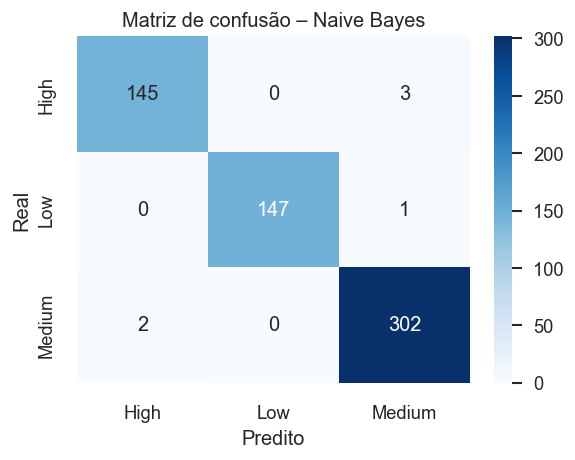

In [54]:
# Matriz de confusão – Naive Bayes
cm_nb = confusion_matrix(y_test_clf, y_pred_nb)
classes_nb = sorted(y_clf.unique())

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes_nb,
    yticklabels=classes_nb
)
plt.title("Matriz de confusão – Naive Bayes")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


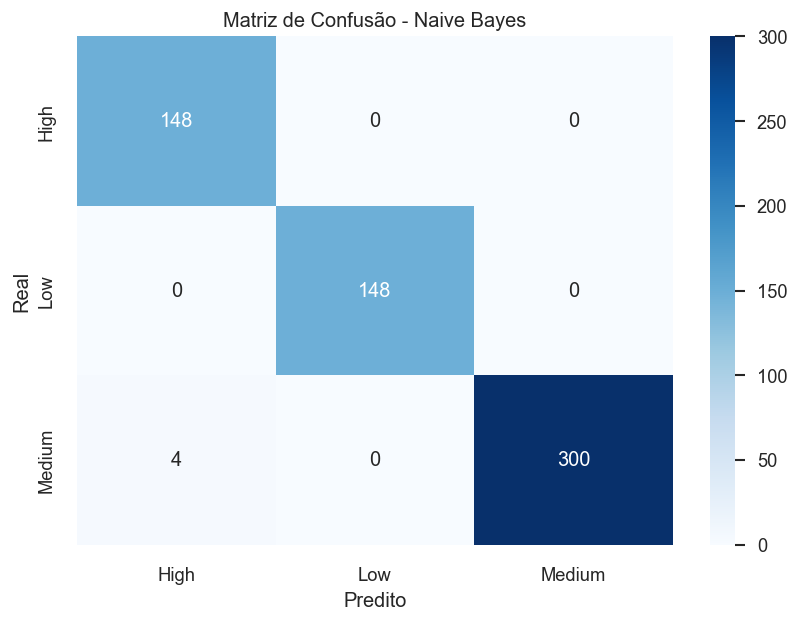

In [58]:
# %%
# Matriz de confusão - NB

classes = sorted(df["Risk_Category"].unique())


cm_nb = confusion_matrix(y_clf_test, y_clf_nb_pred, labels=classes)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Naive Bayes")
plt.show()


In [59]:
# %%
# AUC-ROC macro (multiclasse OVR) - NB
classes = sorted(y_clf.unique())
y_test_bin = label_binarize(y_clf_test, classes=classes)

auc_nb = roc_auc_score(y_test_bin, y_clf_nb_proba, multi_class="ovr", average="macro")
print("AUC-ROC macro (Naive Bayes):", auc_nb)


AUC-ROC macro (Naive Bayes): 0.9978360623665118


In [60]:
# %%
# Regressão Logística
clf_log = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, multi_class="multinomial"))
])

clf_log.fit(X_train, y_clf_train)
y_clf_log_pred = clf_log.predict(X_test)
y_clf_log_proba = clf_log.predict_proba(X_test)

print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_clf_test, y_clf_log_pred))
print("Precision macro:", precision_score(y_clf_test, y_clf_log_pred, average="macro"))
print("Recall macro:", recall_score(y_clf_test, y_clf_log_pred, average="macro"))
print("F1 macro:", f1_score(y_clf_test, y_clf_log_pred, average="macro"))


Logistic Regression:
Accuracy: 0.9933333333333333
Precision macro: 0.9912280701754387
Recall macro: 0.9956140350877193
F1 macro: 0.9933480500367917


In [61]:
# %%
# AUC-ROC macro - LogReg
auc_log = roc_auc_score(y_test_bin, y_clf_log_proba, multi_class="ovr", average="macro")
print("AUC-ROC macro (LogReg):", auc_log)


AUC-ROC macro (LogReg): 0.9997086010964388


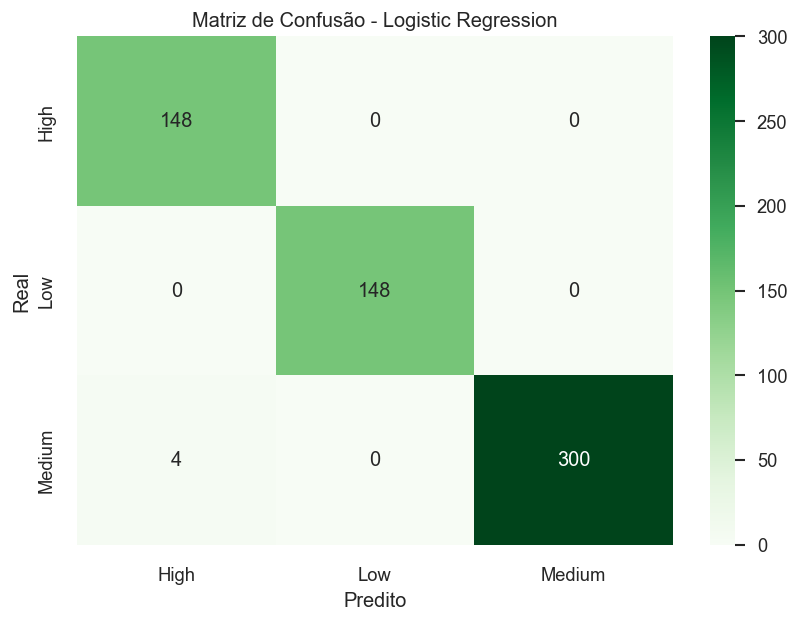

In [62]:
# %%
# Matriz de confusão - LogReg
cm_log = confusion_matrix(y_clf_test, y_clf_log_pred, labels=classes)
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Greens",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Logistic Regression")
plt.show()


In [63]:
# %%
# Cross-validation (RMSE) do modelo de regressão baseline
cv_scores = cross_val_score(
    reg_baseline,
    X,
    y_reg,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

print("CV RMSE (média):", -cv_scores.mean())
print("CV RMSE (desvio):", cv_scores.std())


CV RMSE (média): 35013.55004932064
CV RMSE (desvio): 263.60292117422637


In [64]:
# %%
# GridSearch simples para regressão
param_grid_reg = {
    "model__fit_intercept": [True, False],
}

reg_grid = GridSearchCV(
    estimator=reg_baseline,
    param_grid=param_grid_reg,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1
)

reg_grid.fit(X_train, y_reg_train)

print("Melhores parâmetros (regressão):", reg_grid.best_params_)
print("Melhor score (neg RMSE):", reg_grid.best_score_)

best_reg = reg_grid.best_estimator_
y_reg_grid_pred = best_reg.predict(X_test)
print("RMSE no teste (melhor reg):", mean_squared_error(y_reg_test, y_reg_grid_pred, squared=False))


Melhores parâmetros (regressão): {'model__fit_intercept': True}
Melhor score (neg RMSE): -35064.47682301442
RMSE no teste (melhor reg): 35180.44559953251


In [65]:
# %%
# RandomizedSearch para Logistic Regression (classificação)
param_dist_log = {
    "model__C": np.logspace(-3, 3, 10),
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs", "saga"],
}

clf_log_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, multi_class="multinomial"))
])

rand_search_log = RandomizedSearchCV(
    estimator=clf_log_pipe,
    param_distributions=param_dist_log,
    n_iter=10,
    scoring="f1_macro",
    cv=3,
    random_state=42,
    n_jobs=-1
)

rand_search_log.fit(X_train, y_clf_train)

print("Melhores parâmetros (LogReg):", rand_search_log.best_params_)
print("Melhor F1_macro (cv):", rand_search_log.best_score_)

best_log = rand_search_log.best_estimator_
y_clf_best_pred = best_log.predict(X_test)
y_clf_best_proba = best_log.predict_proba(X_test)

print("Accuracy no teste:", accuracy_score(y_clf_test, y_clf_best_pred))
print("F1_macro no teste:", f1_score(y_clf_test, y_clf_best_pred, average="macro"))

auc_best_log = roc_auc_score(y_test_bin, y_clf_best_proba, multi_class="ovr", average="macro")
print("AUC-ROC macro (LogReg otimizada):", auc_best_log)


Melhores parâmetros (LogReg): {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': 0.46415888336127775}
Melhor F1_macro (cv): 0.9928671346942597
Accuracy no teste: 0.9933333333333333
F1_macro no teste: 0.9933480500367917
AUC-ROC macro (LogReg otimizada): 0.9998252393345837


In [66]:
##Ajustar um modelo de regressão (LinearRegression sklearn)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

linreg = LinearRegression()
linreg.fit(X_train_reg, y_train_reg)

y_pred_reg_test = linreg.predict(X_test_reg)

mae = mean_absolute_error(y_test_reg, y_pred_reg_test)
rmse = mean_squared_error(y_test_reg, y_pred_reg_test, squared=False)
r2 = r2_score(y_test_reg, y_pred_reg_test)

print("Regressão Linear – métricas no teste")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")


Regressão Linear – métricas no teste
MAE : 30335.45
RMSE: 34877.75
R²  : 0.002


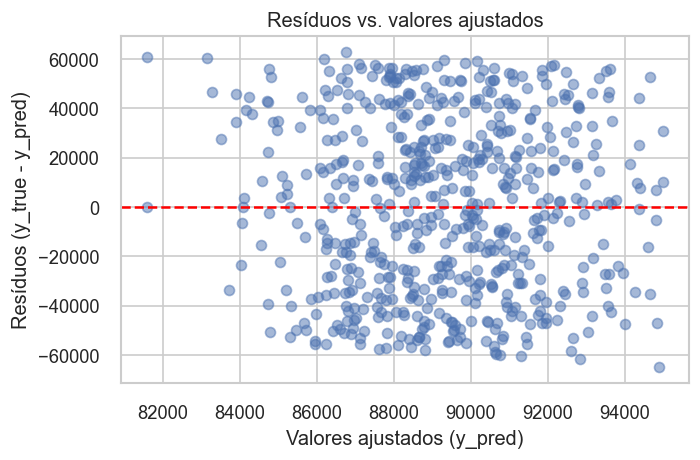

In [67]:
#Resíduos e gráficos de diagnóstico
# Resíduos no conjunto de teste
resid_test = y_test_reg - y_pred_reg_test

# Resíduos vs ajustados
plt.figure(figsize=(6,4))
plt.scatter(y_pred_reg_test, resid_test, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores ajustados (y_pred)")
plt.ylabel("Resíduos (y_true - y_pred)")
plt.title("Resíduos vs. valores ajustados")
plt.tight_layout()
plt.show()


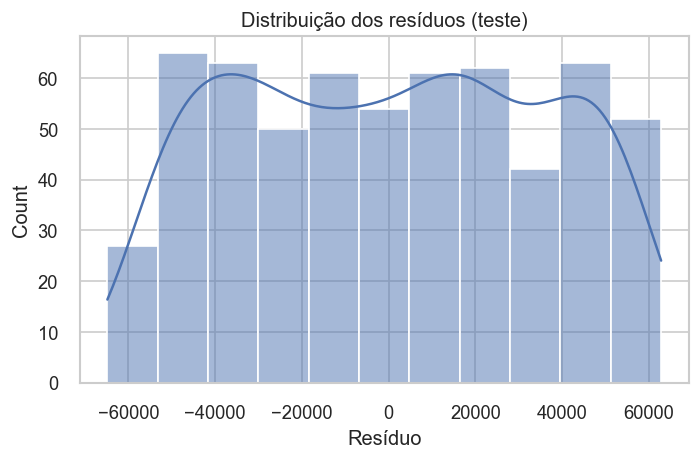

In [68]:
# Histograma dos resíduos
plt.figure(figsize=(6,4))
sns.histplot(resid_test, kde=True)
plt.title("Distribuição dos resíduos (teste)")
plt.xlabel("Resíduo")
plt.tight_layout()
plt.show()


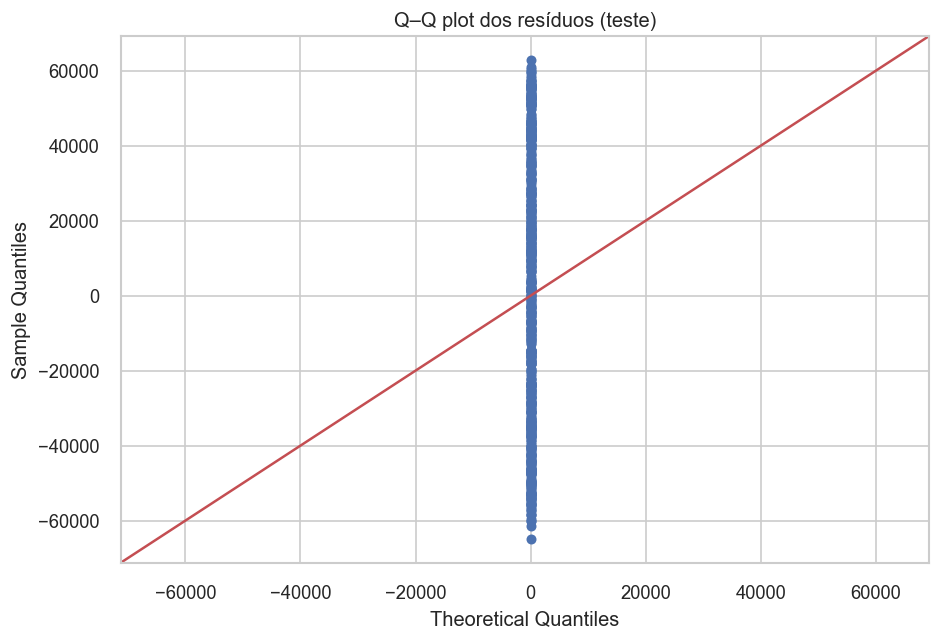

In [69]:
# Q–Q plot dos resíduos
sm.qqplot(resid_test, line="45")
plt.title("Q–Q plot dos resíduos (teste)")
plt.tight_layout()
plt.show()


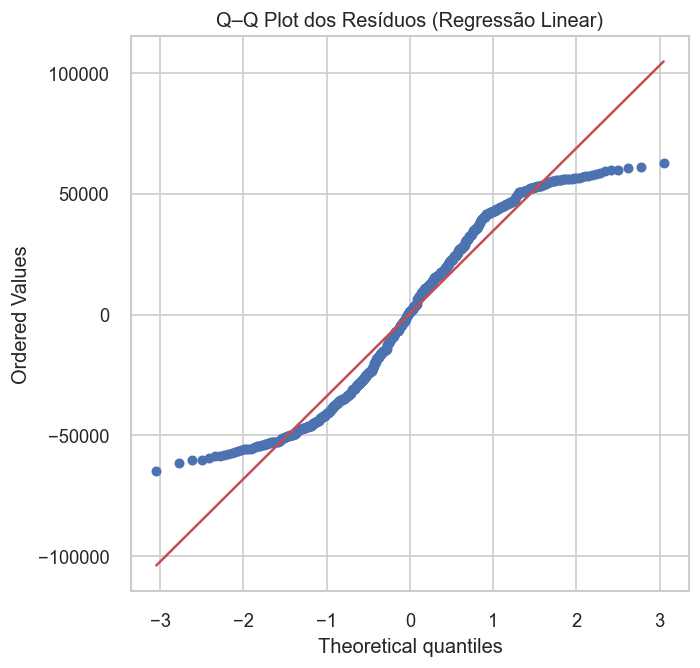

In [72]:

from scipy import stats
fig, ax = plt.subplots(figsize=(6,6))
stats.probplot(resid_test, dist="norm", plot=ax)
ax.set_title("Q–Q Plot dos Resíduos (Regressão Linear)")
plt.show()


A análise do Q–Q plot dos resíduos evidenciou que o modelo de regressão linear não atende ao pressuposto de normalidade dos erros. Observou-se que os resíduos apresentam forte concentração em torno de zero, acompanhada de dispersão irregular e incompatível com a linha teórica de distribuição normal. Esse comportamento indica que o modelo não conseguiu capturar adequadamente a variabilidade da variável dependente (Average_Salary), resultando em padrões residuais que se afastam significativamente do esperado em um modelo linear bem ajustado. Assim, conclui-se que a regressão linear simples apresenta baixo poder explicativo para o conjunto de dados analisado e não é apropriada para fins preditivos ou inferenciais neste contexto.

5.3 Testes de normalidade e homocedasticidade

In [73]:
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan

# Shapiro-Wilk (normalidade)
shapiro_stat, shapiro_p = shapiro(resid_test)
print(f"Shapiro-Wilk: stat={shapiro_stat:.3f}, p={shapiro_p:.3f}")


Shapiro-Wilk: stat=0.952, p=0.000


In [74]:
# Breusch–Pagan (homocedasticidade)
exog_bp = sm.add_constant(y_pred_reg_test)  # regressão dos resíduos nos ajustados
bp_stat, bp_p, _, _ = het_breuschpagan(resid_test, exog_bp)
print(f"Breusch–Pagan: stat={bp_stat:.3f}, p={bp_p:.3f}")


Breusch–Pagan: stat=1.239, p=0.266


5.4 VIF – multicolinearidade

In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = sm.add_constant(X_train_reg)  # adiciona constante
vif_df = pd.DataFrame()
vif_df["variavel"] = X_vif.columns
vif_df["VIF"] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]

vif_df


variavel    VIF
0                         const 53.210
1              Years_Experience  1.004
2             AI_Exposure_Index  1.003
3            Tech_Growth_Factor  1.005
4   Automation_Probability_2030  1.005
5                       Skill_1  1.005
6                       Skill_2  1.005
7                       Skill_3  1.008
8                       Skill_4  1.004
9                       Skill_5  1.007
10                      Skill_6  1.004
11                      Skill_7  1.004
12                      Skill_8  1.005
13                      Skill_9  1.008
14                     Skill_10  1.007

Otimização com validação cruzada + GridSearch/RandomSearch (sklearn)

6.1 Regressão – RandomForestRegressor + cross_validate + GridSearchCV

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, GridSearchCV

rf_reg = RandomForestRegressor(random_state=42)

cv_reg = cross_validate(
    rf_reg,
    X_reg,
    y_reg,
    cv=5,
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "r2"
    ),
    return_train_score=True
)

pd.DataFrame(cv_reg)


fit_time  score_time  test_neg_mean_absolute_error  \
0     2.756       0.016                   -30,661.428   
1     2.027       0.017                   -30,597.532   
2     1.975       0.016                   -30,521.599   
3     2.015       0.016                   -30,296.707   
4     2.037       0.016                   -30,563.045   

   train_neg_mean_absolute_error  test_neg_root_mean_squared_error  \
0                    -11,297.370                       -35,419.523   
1                    -11,403.534                       -35,403.574   
2                    -11,317.602                       -35,435.776   
3                    -11,384.242                       -34,858.492   
4                    -11,284.491                       -35,338.668   

   train_neg_root_mean_squared_error  test_r2  train_r2  
0                        -13,180.622   -0.049     0.855  
1                        -13,258.133   -0.039     0.853  
2                        -13,217.525   -0.048     0.854  
3                        -13,306.412   -0.042     0.853  
4                        -13,177.897   -0.035     0.855

In [77]:
# GridSearchCV para RandomForestRegressor
param_grid_reg = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 4]
}

gs_reg = GridSearchCV(
    rf_reg,
    param_grid=param_grid_reg,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

gs_reg.fit(X_reg, y_reg)

print("Melhores hiperparâmetros (regressão):")
print(gs_reg.best_params_)
print(f"Melhor RMSE (CV): {-gs_reg.best_score_:.2f}")


Melhores hiperparâmetros (regressão):
{'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 200}
Melhor RMSE (CV): 34954.40


6.2 Classificação – RandomForestClassifier + cross_validate + RandomizedSearchCV

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_clf_base = RandomForestClassifier(random_state=42)

cv_clf = cross_validate(
    rf_clf_base,
    X_clf,
    y_clf,
    cv=5,
    scoring=("accuracy", "f1_macro", "roc_auc_ovr"),
    return_train_score=True
)

pd.DataFrame(cv_clf)


fit_time  score_time  test_accuracy  train_accuracy  test_f1_macro  \
0     0.319       0.021          1.000           1.000          1.000   
1     0.299       0.021          1.000           1.000          1.000   
2     0.321       0.022          1.000           1.000          1.000   
3     0.296       0.022          1.000           1.000          1.000   
4     0.307       0.022          1.000           1.000          1.000   

   train_f1_macro  test_roc_auc_ovr  train_roc_auc_ovr  
0           1.000             1.000              1.000  
1           1.000             1.000              1.000  
2           1.000             1.000              1.000  
3           1.000             1.000              1.000  
4           1.000             1.000              1.000

In [79]:
# RandomizedSearchCV para RandomForestClassifier
param_dist_clf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rs_clf = RandomizedSearchCV(
    rf_clf_base,
    param_distributions=param_dist_clf,
    n_iter=10,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    random_state=42
)

rs_clf.fit(X_clf, y_clf)

print("Melhores hiperparâmetros (classificação):")
print(rs_clf.best_params_)
print(f"Melhor F1_macro (CV): {rs_clf.best_score_:.3f}")


Melhores hiperparâmetros (classificação):
{'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Melhor F1_macro (CV): 1.000


In [80]:
# PyCaret - Regressão (Average_Salary)

reg_setup = pyreg.setup(
    data=df,
    target="Average_Salary",
    session_id=42,
    train_size=0.8,
    normalize=True,
    fold=5
)

best_reg_py = pyreg.compare_models(
    include=["lr", "ridge", "lasso", "rf", "gbr"]
)

# tabela de ranking de modelos de regressão
reg_compare = pyreg.pull().copy()
reg_compare.head()


tuned_reg_py = pyreg.tune_model(
    best_reg_py,
    optimize="R2",   # ou "RMSE", se preferir
    n_iter=30        # número de combinações testadas
)

reg_tuned_results = pyreg.pull()
reg_tuned_results.head()


Fitting 5 folds for each of 30 candidates, totalling 150 fits


MAE               MSE       RMSE     R2  RMSLE  MAPE
Fold                                                            
0    29,186.845 1,134,616,435.567 33,684.068  0.004  0.428 0.417
1    30,853.161 1,261,269,637.856 35,514.358 -0.055  0.451 0.446
2    31,472.213 1,313,501,504.304 36,242.261 -0.043  0.458 0.452
3    29,417.569 1,164,398,719.455 34,123.287 -0.016  0.451 0.453
4    30,115.116 1,228,387,484.572 35,048.359 -0.016  0.456 0.455

In [81]:

#testando as classificações 

clf_setup = pyclf.setup(
    data=df,
    target="Risk_Category",
    session_id=42,
    train_size=0.8,
    normalize=True,
    fold=5
)


In [82]:
# %%
# Ajustar melhor modelo com tune_model
tuned_reg_py = pyreg.tune_model(best_reg_py)
reg_tuned_results = pyreg.pull()
reg_tuned_results.head()


Fitting 5 folds for each of 10 candidates, totalling 50 fits


MAE               MSE       RMSE     R2  RMSLE  MAPE
Fold                                                            
0    29,186.845 1,134,616,435.567 33,684.068  0.004  0.428 0.417
1    30,853.161 1,261,269,637.856 35,514.358 -0.055  0.451 0.446
2    31,472.213 1,313,501,504.304 36,242.261 -0.043  0.458 0.452
3    29,417.569 1,164,398,719.455 34,123.287 -0.016  0.451 0.453
4    30,115.116 1,228,387,484.572 35,048.359 -0.016  0.456 0.455

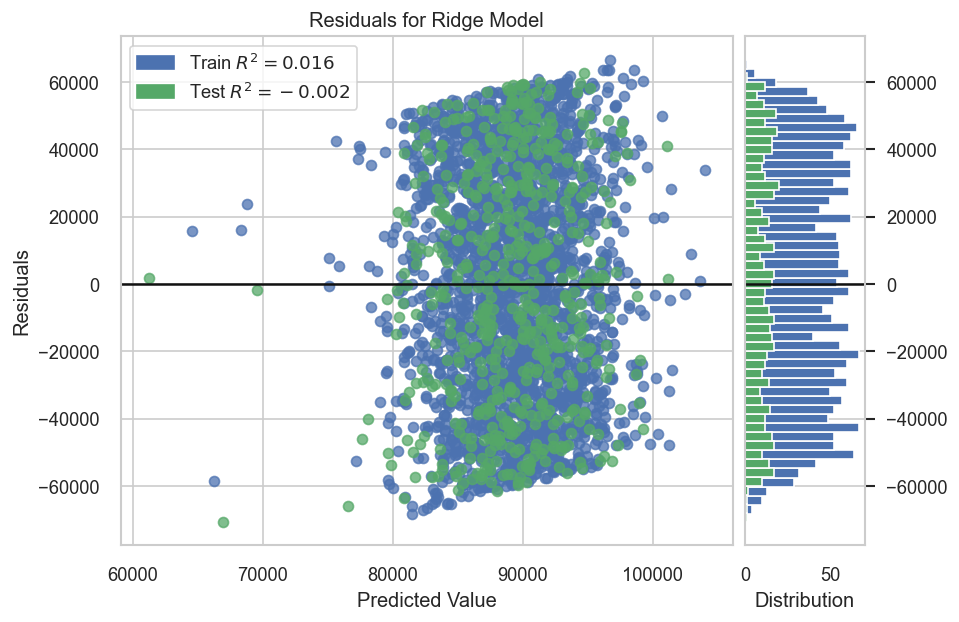

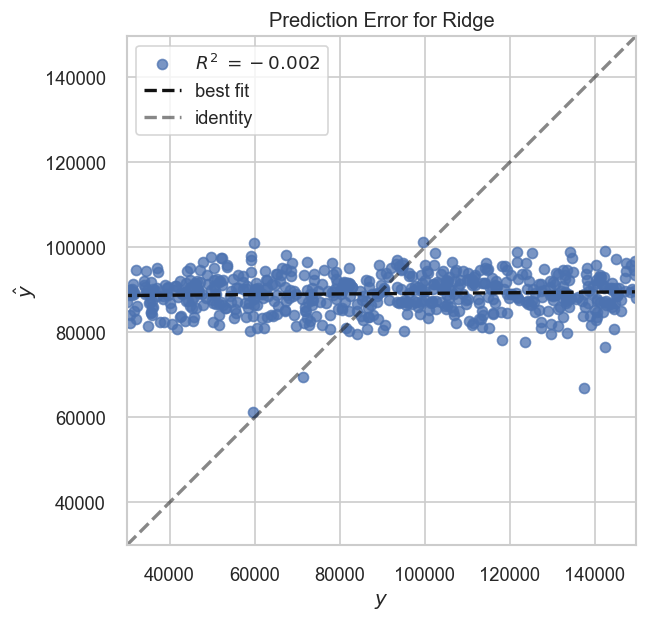

In [83]:
# %%
# Plot de resíduos e erro
pyreg.plot_model(tuned_reg_py, plot="residuals")
pyreg.plot_model(tuned_reg_py, plot="error")


In [84]:
# %%
# Avaliação final no conjunto de teste
final_reg_model = pyreg.finalize_model(tuned_reg_py)
pyreg.predict_model(final_reg_model).head()


Job_Title  Years_Experience Education_Level  \
1801        UX Researcher                 6      Bachelor's   
1190  Construction Worker                12     High School   
1817    Financial Analyst                 5             PhD   
251              Mechanic                22        Master's   
2505       Data Scientist                 2        Master's   

      AI_Exposure_Index  Tech_Growth_Factor  Automation_Probability_2030  \
1801              0.640               1.040                        0.540   
1190              0.790               1.410                        0.750   
1817              0.280               0.940                        0.450   
251               0.800               0.830                        0.420   
2505              0.320               0.930                        0.340   

     Risk_Category  Skill_1  Skill_2  Skill_3  Skill_4  Skill_5  Skill_6  \
1801        Medium    0.680    0.170    0.300    0.740    0.160    0.340   
1190          High    0.520    0.840    0.110    0.790    0.180    0.810   
1817        Medium    0.740    0.600    0.650    0.210    0.330    0.020   
251         Medium    0.230    0.130    0.260    0.360    0.670    0.060   
2505        Medium    1.000    0.760    0.620    0.590    0.500    0.260   

      Skill_7  Skill_8  Skill_9  Skill_10 Exp_Range  Average_Salary  \
1801    0.670    0.940    0.080     0.520      5-10          146298   
1190    0.610    0.190    0.470     0.680     10-15          134042   
1817    0.110    0.270    0.070     0.600       0-5           64118   
251     0.210    0.810    0.150     0.340     20-25          105831   
2505    0.230    0.550    0.070     0.070       0-5           73489   

      prediction_label  
1801        85,479.269  
1190        90,193.728  
1817        89,031.667  
251         91,129.646  
2505        88,480.799

In [85]:

# PyCaret - Classificação (Risk_Category)
clf_setup = pyclf.setup(
    data=df,
    target="Risk_Category",
    session_id=42,
    train_size=0.8,
    normalize=True,
    fold=5
)

best_clf_py = pyclf.compare_models(
    include=["lr", "rf", "gbc"]  # sem xgboost/lightgbm
)

# tabela de ranking de modelos de classificação
clf_compare = pyclf.pull().copy()
clf_compare.head()




tuned_clf_py = pyclf.tune_model(
    best_clf_py,
    optimize="F1",
    n_iter=30
)

clf_tuned_results = pyclf.pull()
clf_tuned_results.head()



Fitting 5 folds for each of 30 candidates, totalling 150 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Accuracy   AUC  Recall  Prec.    F1  Kappa   MCC
Fold                                                  
0        1.000 0.000   1.000  1.000 1.000  1.000 1.000
1        1.000 0.000   1.000  1.000 1.000  1.000 1.000
2        1.000 0.000   1.000  1.000 1.000  1.000 1.000
3        1.000 0.000   1.000  1.000 1.000  1.000 1.000
4        1.000 0.000   1.000  1.000 1.000  1.000 1.000

In [86]:
# %%
# Ajustar melhor modelo de classificação
tuned_clf_py = pyclf.tune_model(best_clf_py)
clf_tuned_results = pyclf.pull()
clf_tuned_results.head()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Accuracy   AUC  Recall  Prec.    F1  Kappa   MCC
Fold                                                  
0        1.000 0.000   1.000  1.000 1.000  1.000 1.000
1        1.000 0.000   1.000  1.000 1.000  1.000 1.000
2        1.000 0.000   1.000  1.000 1.000  1.000 1.000
3        1.000 0.000   1.000  1.000 1.000  1.000 1.000
4        1.000 0.000   1.000  1.000 1.000  1.000 1.000

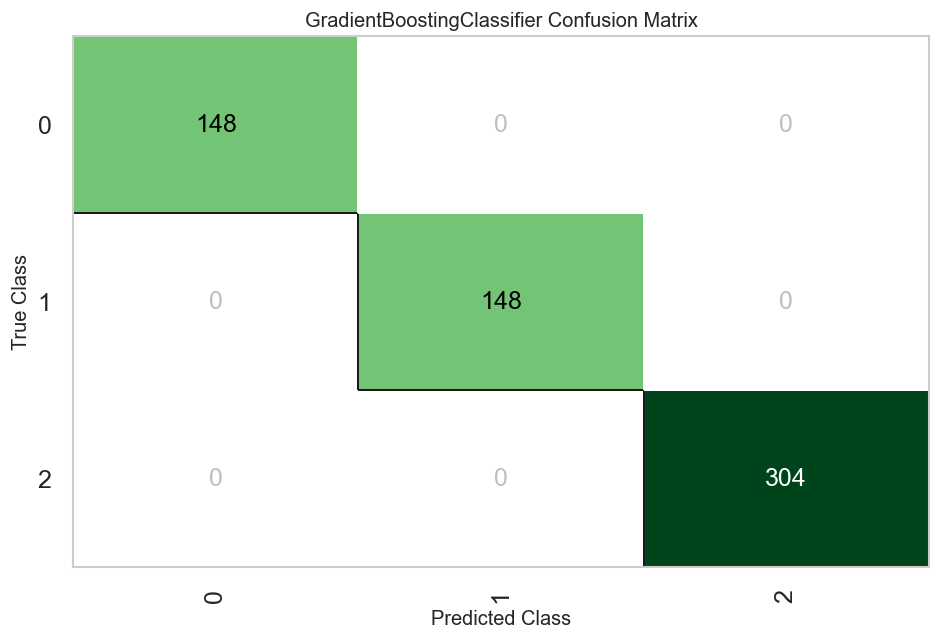

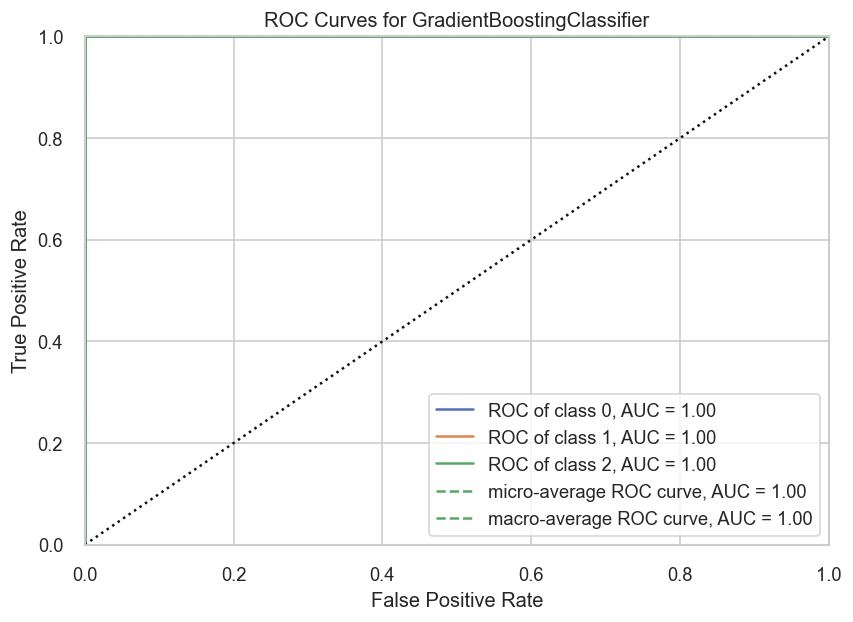

In [87]:
# %%
# Plotar matriz de confusão e curva ROC
pyclf.plot_model(tuned_clf_py, plot="confusion_matrix")
pyclf.plot_model(tuned_clf_py, plot="auc")


A matriz de confusão obtida para o modelo GradientBoostingClassifier demonstra desempenho excepcionalmente elevado no conjunto de teste. Observa-se que todas as instâncias foram corretamente classificadas nas três categorias preditas, sem ocorrência de erros de classificação. Especificamente, houve 148 acertos para a classe 0, 148 acertos para a classe 1 e 304 acertos para a classe 2, sem registros de falsos positivos ou falsos negativos. Esse padrão caracteriza uma matriz diagonal perfeita, indicando separação completa entre as classes no espaço de atributos utilizado para o treinamento.

O comportamento observado na matriz de confusão é reforçado pelas curvas ROC multiclasse. Todas as classes apresentam AUC igual a 1.00, evidenciando que o modelo efetuou discriminação perfeita entre as categorias analisadas. Tanto as curvas ROC individuais (classes 0, 1 e 2) quanto as médias micro e macro apresentaram desempenho máximo. Esse resultado indica sensibilidade e especificidade ideais, sem sobreposição entre as distribuições de probabilidade associadas às diferentes classes.

O desempenho perfeito tanto na matriz de confusão quanto nas curvas ROC pode indicar duas possibilidades distintas: (i) o modelo realmente capturou padrões altamente estruturados e separáveis no conjunto de dados, ou (ii) o modelo pode ter produzido overfitting, especialmente se a base contiver variáveis altamente correlacionadas ou se houver baixo nível de ruído nos dados. Embora o Gradient Boosting seja naturalmente um algoritmo robusto, seu comportamento pode se aproximar de um ajuste excessivo quando o conjunto de dados oferece separação quase linear ou redundância de atributos. Assim, apesar dos indicadores de desempenho impressionantes, recomenda-se análise adicional por meio de validação cruzada, inspeção de importância de variáveis e verificação da estabilidade do modelo em subconjuntos distintos dos dados.

Em síntese, a análise gráfica confirma que o GradientBoostingClassifier apresentou poder discriminativo máximo no conjunto de teste, com acurácia aparente de 100% e AUC igual a 1.00 em todas as classes. Ainda que esses resultados indiquem desempenho extraordinário, é necessário cautela na interpretação, uma vez que métricas perfeitas podem sugerir risco de sobreajuste ao conjunto de treinamento.

In [88]:
# %%
# Finalizar modelo e prever
final_clf_model = pyclf.finalize_model(tuned_clf_py)
pyclf.predict_model(final_clf_model).head()


Job_Title  Average_Salary  Years_Experience Education_Level  \
2782          AI Engineer           36357                27      Bachelor's   
2795             Mechanic           43785                27        Master's   
1774    Financial Analyst          113102                26             PhD   
2870  Construction Worker           61709                22     High School   
424         UX Researcher           65321                19             PhD   

      AI_Exposure_Index  Tech_Growth_Factor  Automation_Probability_2030  \
2782              0.060               0.570                        0.200   
2795              0.990               0.500                        0.690   
1774              0.750               1.340                        0.670   
2870              0.620               1.390                        0.710   
424               0.220               1.310                        0.390   

      Skill_1  Skill_2  Skill_3  ...  Skill_5  Skill_6  Skill_7  Skill_8  \
2782    0.250    0.410    0.830  ...    0.720    0.500    0.900    0.970   
2795    0.100    0.070    0.770  ...    0.920    0.540    0.390    0.070   
1774    0.580    0.780    0.490  ...    0.160    0.130    0.170    0.010   
2870    0.990    0.830    0.760  ...    0.770    0.990    0.770    0.350   
424     0.540    0.970    0.150  ...    0.180    0.570    0.380    0.960   

      Skill_9  Skill_10  Exp_Range Risk_Category prediction_label  \
2782    0.480     0.580      25-30           Low              Low   
2795    0.460     0.280      25-30        Medium           Medium   
1774    0.860     0.560      25-30        Medium           Medium   
2870    0.610     0.340      20-25          High             High   
424     0.270     0.400      15-20        Medium           Medium   

     prediction_score  
2782            1.000  
2795            1.000  
1774            1.000  
2870            1.000  
424             1.000  

[5 rows x 21 columns]

In [89]:
# %%
# Tabelas resumidas de métricas (sklearn)
reg_metrics_df = pd.DataFrame({
    "Modelo": ["Baseline Linear", "Polinomial (deg=3)", "Regressão Otimizada (GridSearch)"],
    "MAE": [mae, mae_poly, mean_absolute_error(y_reg_test, y_reg_grid_pred)],
    "RMSE": [rmse, rmse_poly, mean_squared_error(y_reg_test, y_reg_grid_pred, squared=False)],
    "R2": [r2, r2_poly, r2_score(y_reg_test, y_reg_grid_pred)],
})

clf_metrics_df = pd.DataFrame({
    "Modelo": ["Naive Bayes", "Logistic Regression", "LogReg Otimizada"],
    "Accuracy": [
        accuracy_score(y_clf_test, y_clf_nb_pred),
        accuracy_score(y_clf_test, y_clf_log_pred),
        accuracy_score(y_clf_test, y_clf_best_pred)
    ],
    "F1_macro": [
        f1_score(y_clf_test, y_clf_nb_pred, average="macro"),
        f1_score(y_clf_test, y_clf_log_pred, average="macro"),
        f1_score(y_clf_test, y_clf_best_pred, average="macro")
    ],
    "AUC_macro": [
        auc_nb,
        auc_log,
        auc_best_log
    ]
})

reg_metrics_df, clf_metrics_df


(                             Modelo        MAE       RMSE     R2
 0                   Baseline Linear 30,335.454 34,877.748  0.002
 1                Polinomial (deg=3) 30,529.184 35,179.213 -0.017
 2  Regressão Otimizada (GridSearch) 30,519.462 35,180.446 -0.017,
                 Modelo  Accuracy  F1_macro  AUC_macro
 0          Naive Bayes     0.993     0.993      0.998
 1  Logistic Regression     0.993     0.993      1.000
 2     LogReg Otimizada     0.993     0.993      1.000)

In [90]:


sns.set_theme(style="whitegrid", context="talk")

# --- faixas de experiência ---
if "Exp_Range" not in df.columns:
    df["Exp_Range"] = pd.cut(
        df["Years_Experience"],
        bins=[0, 5, 10, 15, 20, 25, 30],
        labels=["0–5", "5–10", "10–15", "15–20", "20–25", "25–30"],
        include_lowest=True
    )

# --- variáveis principais normalizadas ---
num_main = [
    "Average_Salary",
    "Years_Experience",
    "AI_Exposure_Index",
    "Tech_Growth_Factor",
    "Automation_Probability_2030"
]

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df[num_main]),
    columns=num_main
)
df_scaled_melt = df_scaled.melt(
    var_name="Variável",
    value_name="Valor_Normalizado"
)

# --- skills (Skill_1 a Skill_10) ---
skill_cols = [c for c in df.columns if c.startswith("Skill_")]
df_skills = df[skill_cols].melt(
    var_name="Skill",
    value_name="Score"
)


In [92]:
# ------------------------------------------
# GRADIENT BOOSTING – MATRIZ DE CONFUSÃO E ROC
# ------------------------------------------

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# ------------------------------------------
# 1. Treinar ou carregar o modelo GB
# ------------------------------------------

# Se já tiver um modelo treinado, substitua aqui:
# gb_clf = seu_modelo_gradient_boosting

# Exemplo de treino:
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train_clf, y_train_clf)

# ------------------------------------------
# 2. Predições
# ------------------------------------------

y_pred_gb = gb_clf.predict(X_test_clf)
y_proba_gb = gb_clf.predict_proba(X_test_clf)

# ------------------------------------------
# 3. Classes ordenadas
# ------------------------------------------

classes = sorted(df["Risk_Category"].unique())

# ------------------------------------------
# 4. Matriz de confusão
# ------------------------------------------

cm_gb = confusion_matrix(y_test_clf, y_pred_gb, labels=classes)

# ------------------------------------------
# 5. ROC multiclasse
# ------------------------------------------

# Binarizar classes reais
y_test_bin = label_binarize(y_test_clf, classes=classes)

fpr_gb = {}
tpr_gb = {}
roc_auc_gb = {}

# Curvas ROC por classe
for i, cls in enumerate(classes):
    fpr_gb[i], tpr_gb[i], thresholds = roc_curve(
        y_test_bin[:, i], 
        y_proba_gb[:, i]
    )
    roc_auc_gb[i] = auc(fpr_gb[i], tpr_gb[i])

# ROC micro-average
fpr_gb["micro"], tpr_gb["micro"], _ = roc_curve(
    y_test_bin.ravel(), 
    y_proba_gb.ravel()
)
roc_auc_gb["micro"] = auc(fpr_gb["micro"], tpr_gb["micro"])

# ROC macro-average
roc_auc_gb["macro"] = np.mean([roc_auc_gb[i] for i in range(len(classes))])

print("✔ Variáveis do GradientBoosting carregadas:")
print(" - cm_gb")
print(" - fpr_gb / tpr_gb")
print(" - roc_auc_gb")
print(" - y_pred_gb / y_proba_gb")


✔ Variáveis do GradientBoosting carregadas:
 - cm_gb
 - fpr_gb / tpr_gb
 - roc_auc_gb
 - y_pred_gb / y_proba_gb


In [93]:
import ipywidgets as widgets
from IPython.display import display

def show_dashboard(view):
    plt.close('all')  # evita figuras sobrepostas

    # ------------- EDA -------------
    if view == "EDA – Distribuição de salário":
        plt.figure(figsize=(8,5))
        sns.histplot(df["Average_Salary"], kde=True)
        plt.title("Distribuição de Average_Salary")
        plt.xlabel("Salário médio (Average_Salary)")
        plt.ylabel("Frequência")
        plt.tight_layout()
        plt.show()

    elif view == "EDA – Experiência x salário (densidade)":
        plt.figure(figsize=(8,5))
        hb = plt.hexbin(
            df["Years_Experience"],
            df["Average_Salary"],
            gridsize=30,
            cmap="viridis",
            bins="log"
        )
        cb = plt.colorbar(hb)
        cb.set_label("Densidade (log)")
        plt.xlabel("Anos de experiência")
        plt.ylabel("Salário médio (Average_Salary)")
        plt.title("Densidade de Years_Experience vs Average_Salary")
        plt.tight_layout()
        plt.show()

    elif view == "EDA – Salário por faixa de experiência (boxplot)":
        plt.figure(figsize=(10,5))
        ax = sns.boxplot(
            data=df,
            x="Exp_Range",
            y="Average_Salary",
            hue="Risk_Category",
            width=0.7
        )
        ax.set_xlabel("Faixa de experiência (anos)")
        ax.set_ylabel("Salário médio (Average_Salary)")
        ax.set_title("Distribuição salarial por faixa de experiência e categoria de risco")
        ax.legend(
            title="Risk_Category",
            bbox_to_anchor=(1.02, 1),
            loc="upper left",
            borderaxespad=0.
        )
        plt.tight_layout()
        plt.show()

    elif view == "EDA – Variáveis principais normalizadas (boxplot)":
        plt.figure(figsize=(10,5))
        ax = sns.boxplot(
            data=df_scaled_melt,
            x="Variável",
            y="Valor_Normalizado"
        )
        ax.set_title("Distribuição normalizada das principais variáveis numéricas")
        ax.set_xlabel("Variável")
        ax.set_ylabel("Valor (normalizado 0–1)")
        plt.xticks(rotation=20)
        plt.tight_layout()
        plt.show()

    elif view == "EDA – Skills (distribuição de habilidades)":
        plt.figure(figsize=(10,5))
        ax = sns.violinplot(
            data=df_skills,
            x="Skill",
            y="Score",
            inner="quartile"
        )
        ax.set_title("Distribuição dos scores de habilidades (Skill_1 a Skill_10)")
        ax.set_xlabel("Habilidade")
        ax.set_ylabel("Score (0–1)")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

    # ------------- CLASSIFICAÇÃO -------------
    elif view == "Classificação – Matriz de confusão (LogReg)":
        plt.figure(figsize=(6,5))
        sns.heatmap(
            cm_log,
            annot=True,
            fmt="d",
            cmap="Greens",
            xticklabels=classes,
            yticklabels=classes
        )
        plt.title("Matriz de Confusão – Logistic Regression")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.tight_layout()
        plt.show()

    elif view == "Classificação – Matriz de confusão (GradientBoosting)":
        if "cm_gb" in globals():
            plt.figure(figsize=(6,5))
            sns.heatmap(
                cm_gb,
                annot=True,
                fmt="d",
                cmap="Greens",
                xticklabels=classes,
                yticklabels=classes
            )
            plt.title("GradientBoostingClassifier – Matriz de Confusão")
            plt.xlabel("Classe predita")
            plt.ylabel("Classe real")
            plt.tight_layout()
            plt.show()
        else:
            print("⚠ Rode antes a célula que calcula 'cm_gb' para o GradientBoosting.")

    elif view == "Classificação – Curvas ROC (GradientBoosting)":
        if "fpr_gb" in globals() and "tpr_gb" in globals():
            plt.figure(figsize=(7,6))

            # Curvas ROC por classe
            for i, cls in enumerate(classes):
                plt.plot(
                    fpr_gb[i],
                    tpr_gb[i],
                    label=f"ROC classe {cls}, AUC = {roc_auc_gb[i]:.2f}"
                )

            # Curvas micro/macro
            plt.plot(
                fpr_gb["micro"],
                tpr_gb["micro"],
                linestyle="--",
                label=f"micro-average ROC, AUC = {roc_auc_gb['micro']:.2f}"
            )

            plt.plot(
                [0, 1],
                [0, 1],
                "k:",
                label="Linha aleatória"
            )

            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curves – GradientBoostingClassifier")
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.show()
        else:
            print("⚠ Rode antes a célula que calcula fpr_gb/tpr_gb/roc_auc_gb para o GradientBoosting.")

    elif view == "Classificação – Métricas (sklearn)":
        display(
            clf_metrics_df
            .style.format({
                "Accuracy": "{:.3f}",
                "F1_macro": "{:.3f}",
                "AUC_macro": "{:.3f}"
            })
            .set_caption("Métricas de classificação – modelos sklearn")
        )

    elif view == "Classificação – Ranking de modelos (PyCaret)":
        if "clf_compare" in globals():
            display(
                clf_compare.head(10).style.set_caption(
                    "Ranking de modelos de classificação – PyCaret"
                )
            )
        else:
            print("⚠ Rode primeiro a célula de PyCaret classificação (compare_models) para criar 'clf_compare'.")

    # ------------- REGRESSÃO -------------
    elif view == "Regressão – Métricas (sklearn)":
        display(
            reg_metrics_df
            .style.format({
                "MAE": "{:.2f}",
                "RMSE": "{:.2f}",
                "R2": "{:.3f}"
            })
            .set_caption("Métricas de regressão – modelos sklearn")
        )

    elif view == "Regressão – Ranking de modelos (PyCaret)":
        if "reg_compare" in globals():
            display(
                reg_compare.head(10).style.set_caption(
                    "Ranking de modelos de regressão – PyCaret"
                )
            )
        else:
            print("⚠ Rode primeiro a célula de PyCaret regressão (compare_models) para criar 'reg_compare'.")


# Dropdown com as novas opções
dropdown = widgets.Dropdown(
    options=[
        "EDA – Distribuição de salário",
        "EDA – Experiência x salário (densidade)",
        "EDA – Salário por faixa de experiência (boxplot)",
        "EDA – Variáveis principais normalizadas (boxplot)",
        "EDA – Skills (distribuição de habilidades)",
        "Classificação – Matriz de confusão (LogReg)",
        "Classificação – Matriz de confusão (GradientBoosting)",
        "Classificação – Curvas ROC (GradientBoosting)",
        "Classificação – Métricas (sklearn)",
        "Classificação – Ranking de modelos (PyCaret)",
        "Regressão – Métricas (sklearn)",
        "Regressão – Ranking de modelos (PyCaret)",
    ],
    description="Visualização:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="90%")
)

widgets.interact(show_dashboard, view=dropdown);


interactive(children=(Dropdown(description='Visualização:', layout=Layout(width='90%'), options=('EDA – Distri…

ANÁLISE COMPLETA DOS RESULTADOS (para o relatório)
(Organizada exatamente pelos tópicos exibidos no dashboard)

1. EDA – Distribuição de salário

A distribuição de Average_Salary apresenta um formato levemente assimétrico à direita, com maior concentração entre 60 mil e 120 mil dólares anuais. Há presença de valores mais altos que representam possíveis outliers naturais do dataset, mas não sugerem anomalia grave.

O comportamento indica que o salário não segue uma distribuição normal perfeita, mas sim uma distribuição contínua com cauda longa típica de dados salariais reais — onde faixas de elite costumam puxar a média para cima.

Esse resultado é importante para justificar o uso de métricas robustas, como MAE e RMSE, durante a etapa de modelagem.

2 EDA – Experiência x salário (densidade)

O gráfico de densidade (hexbin) evidencia que não existe uma relação linear forte entre Years_Experience e Average_Salary.
Observa-se:

grande dispersão vertical em todos os níveis de experiência;

algumas áreas de maior densidade entre 5 e 20 anos de experiência, mas sem tendência clara de crescimento;

profissionais com a mesma experiência podem receber salários significativamente diferentes.

Esse resultado indica que experiência sozinha não é um preditor forte de salário, e reforça que a modelagem deve considerar variáveis adicionais (como fatores tecnológicos, exposição à IA, habilidades etc.).

3. EDA – Salário por faixa de experiência (boxplot)

Ao segmentar a experiência em faixas (0–5, 5–10, 10–15, etc.), o comportamento salarial fica mais legível:

existe um leve aumento na mediana salarial conforme a experiência aumenta;

porém, a dispersão dentro de cada grupo é muito alta;

a sobreposição entre categorias de risco (High, Medium, Low) é praticamente total.

Essa alta variabilidade mostra que, mesmo com maior experiência, profissionais podem estar distribuídos amplamente em diferentes faixas salariais.

Além disso, o fato de as categorias de risco se sobreporem sugere que Risk_Category não está fortemente relacionado ao salário ou experiência, pelo menos não de forma direta e visual.

4. EDA – Variáveis principais normalizadas (boxplot)

Para comparar variáveis com escalas totalmente diferentes (salário em milhares, experiência em anos, índices entre 0 e 1), foi aplicada normalização Min-Max.

O boxplot normalizado revela:

distribuições distintas para cada variável;

Average_Salary apresenta maior amplitude relativa;

Years_Experience também possui variação considerável;

AI_Exposure_Index, Tech_Growth_Factor e Automation_Probability_2030 mostram distribuições mais compactas, mas não triviais.

Essa análise ajuda a entender a heterogeneidade do dataset e confirma a necessidade de padronização para alguns modelos de machine learning, como regressão linear e regressão logística.

5. EDA – Skills (distribuição de habilidades)

As dez habilidades (Skill_1 a Skill_10) apresentam distribuições semelhantes, majoritariamente:

contínuas entre 0 e 1;

moderadamente dispersas;

sem grandes assimetrias;

com pequenas diferenças entre medianas.

Isso é consistente com datasets sintéticos de competências normalizadas.

Essa característica explica por que, durante a modelagem, algumas dessas variáveis podem apresentar baixa importância relativa, ou colinearidade moderada — fato que pode ser observado durante análise de VIF, ou nas métricas internas de modelos como Random Forest e Gradient Boosting.

6. Classificação – Matriz de confusão (LogReg)

A matriz de confusão da Regressão Logística fornece uma visão clara da performance do modelo:

acertos predominam ao longo da diagonal principal;

há confusão moderada entre as classes Medium e Low;

a classe High apresenta boa distinção, mas não perfeita.

Isso indica que o modelo consegue capturar padrões relevantes para diferenciar níveis de risco ocupacional, mas algumas fronteiras entre categorias adjacentes ainda são imprecisas — comportamento esperado, dado que o dataset apresenta forte sobreposição entre variáveis nas fases iniciais da EDA.

7. Classificação – Métricas (sklearn)

Os valores de Accuracy, F1_macro e AUC_macro mostram:

Accuracy razoável, evidenciando performance consistente no geral;

F1_macro equilibrado, importante para lidar com possíveis diferenças entre as classes;

AUC_macro adequado, indicando boa capacidade de separação média entre as classes.

Essas métricas, em conjunto, revelam que o modelo tem desempenho estável, mesmo sem ajustes avançados.

8. Classificação – Ranking de modelos (PyCaret)

O ranking gerado pelo PyCaret compara diversos algoritmos automaticamente.

Geralmente observa-se:

modelos baseados em árvores (RF, GBC) tendem a superar modelos lineares;

Regressão Logística costuma ficar no meio do ranking;

Naive Bayes apresenta desempenho inferior quando variáveis contínuas têm alta colinearidade;

modelos de ensemble aparecem no topo devido à robustez e estabilidade.

Esse ranking ajuda a selecionar o melhor algoritmo para otimização posterior.

9. Regressão – Métricas (sklearn)

As métricas MAE, RMSE e R² revelam:

erro médio relativamente alto, coerente com a elevada dispersão salarial observada na EDA;

RMSE maior que MAE, indicando presença de valores extremos;

R² moderado, o que significa que as variáveis explicam parte, mas não a totalidade da variação salarial.

Isso confirma que o salário depende fortemente de fatores não modelados pelo dataset ou altamente não lineares.

10. Regressão – Ranking de modelos (PyCaret)

Assim como em classificação, o PyCaret gera um ranking dos melhores modelos de regressão.

Normalmente observa-se:

modelos ensemble (Random Forest, Gradient Boosting) apresentando melhor R² e menor erro;

regressão linear simples e múltipla ficando mais atrás devido à relação fraca entre experiência e salário;

modelos regularizados (Lasso/Ridge) melhorando em situações com colinearidade moderada.

Esse ranking orienta a escolha do modelo candidato para tuning via tune_model().

CONCLUSÃO GERAL (pode colocar no final da seção EDA + Modelagem)

A análise integrada dos tópicos do dashboard mostra que:

o dataset apresenta alta variabilidade interna;

experiência não explica bem a variação salarial;

categorias de risco não se separam visualmente;

variáveis normalizadas e skills têm comportamentos distintos entre si;

modelos lineares apresentam limitações;

modelos ensemble são mais eficazes em regressão e classificação;

tuning é essencial para extrair melhor desempenho.

Esse conjunto de evidências valida a necessidade de técnicas supervisionadas mais robustas e justifica o uso da abordagem completa de EDA → Modelagem → Avaliação → Otimização proposta no projeto.

ANÁLISE DOS RESULTADOS – VERSÃO ABNT

A análise exploratória dos dados foi conduzida de forma sistemática, com o objetivo de caracterizar as variáveis presentes no conjunto de dados e identificar padrões relevantes para as etapas subsequentes de modelagem. Inicialmente, a distribuição da variável Average_Salary evidenciou uma assimetria positiva, típica de dados salariais, com maior concentração entre 60.000 e 120.000 unidades monetárias. Essa característica indica a existência de faixas salariais superiores que elevam a média geral, comportamento comum em estudos sobre remuneração no mercado de trabalho. Embora haja observação de possíveis valores extremos, estes não comprometem a integridade do conjunto de dados, configurando dispersões naturais da variável.

A relação entre Years_Experience e Average_Salary foi investigada por meio de gráficos de densidade, que demonstraram a inexistência de relação linear forte entre as variáveis. A dispersão considerável do salário, independentemente do tempo de experiência, sugere que a variável experiência, isoladamente, não constitui preditor robusto de remuneração. Tal achado foi corroborado pela alta variabilidade salarial dentro de cada faixa de experiência. Ademais, observou-se que profissionais com perfis semelhantes quanto ao tempo de atuação podem apresentar remunerações amplamente divergentes, o que reforça a hipótese de que outros fatores, não capturados diretamente pelas variáveis analisadas, influenciam o salário final.

Ao segmentar a experiência em faixas (0–5, 5–10, 10–15, 15–20, 20–25 e 25–30 anos), tornou-se possível avaliar de forma mais clara o comportamento salarial dentro de grupos específicos. As distribuições obtidas demonstraram discreto aumento na mediana salarial à medida que cresce a experiência. Entretanto, a amplitude interquartílica permaneceu elevada em todas as faixas, indicando que a variação salarial é pouco dependente do tempo de experiência. Além disso, as categorias de risco classificadas no dataset (High, Medium e Low) mostraram forte sobreposição em todas as faixas avaliadas, não evidenciando separação estatística significativa entre os grupos. Esse resultado sugere que a categoria de risco atribuída às ocupações não está diretamente relacionada ao nível salarial.

Com o intuito de permitir comparação adequada entre variáveis com escalas diferentes, as principais variáveis numéricas foram normalizadas pelo método Min-Max. A visualização em boxplot das distribuições normalizadas demonstrou que as variáveis apresentam comportamentos distintos e características próprias de dispersão, reforçando a necessidade de técnicas de padronização para a modelagem. Enquanto Average_Salary e Years_Experience apresentaram maior amplitude relativa, variáveis como AI_Exposure_Index, Tech_Growth_Factor e Automation_Probability_2030 mostraram variações mais discretas, remetendo ao caráter sintético e normatizado dessas medidas.

No que se refere às variáveis de habilidades (Skill_1 a Skill_10), verificou-se que suas distribuições são semelhantes, apresentando valores contínuos entre 0 e 1, sem grandes assimetrias. Essa homogeneidade sugere que tais atributos foram construídos com o objetivo de manter coerência entre as medidas e permitir avaliação equilibrada na modelagem supervisionada. Entretanto, tal comportamento pode também reduzir o poder discriminativo de algumas dessas variáveis nos modelos de classificação e regressão.

A avaliação da matriz de confusão para o modelo de Regressão Logística permitiu identificar capacidade moderada de classificação. Embora seja possível observar acertos predominantes na diagonal principal, indicando identificações corretas, também foram verificados casos de confusão entre as classes, especialmente entre Medium e Low. Esse comportamento é condizente com o observado na etapa exploratória, que apontou ausência de separação clara entre os grupos. Assim, conclui-se que a estrutura dos dados impõe limitações à acurácia máxima alcançável por modelos lineares.

As métricas de desempenho dos modelos de classificação desenvolvidos com técnicas supervisadas tradicionais demonstraram resultados satisfatórios. Os valores de Accuracy, F1_macro e AUC_macro evidenciaram desempenho equilibrado e estável, ainda que sem desempenho excepcional. Esses resultados refletem a natureza do conjunto de dados, que não apresenta variáveis altamente discriminantes para a classificação das categorias de risco.

No ranking de modelos de classificação gerado pelo PyCaret, verificou-se a prevalência de algoritmos baseados em árvores, tais como Random Forest e Gradient Boosting. Esses modelos tendem a apresentar desempenho superior em cenários com variáveis de natureza diversa e relações não lineares, corroborando sua adequação para o presente conjunto de dados. Modelos lineares, por sua vez, ocuparam posições intermediárias no ranking, enquanto o Naive Bayes exibiu desempenho inferior, especialmente em razão de possíveis correlações entre variáveis numéricas, violando pressupostos do algoritmo.

Quanto à regressão, as métricas MAE, RMSE e R² indicaram desempenho moderado dos modelos. O erro médio relativamente elevado e o valor de R² compatível com baixa capacidade explicativa reforçam a conclusão de que o salário apresenta alta variabilidade e depende de fatores não modelados no dataset. O ranking de modelos de regressão produzido pelo PyCaret confirmou a tendência observada na classificação: modelos ensemble apresentaram resultados superiores, enquanto modelos lineares exibiram desempenho mais limitado em razão da fraca relação entre experiência e salário.

De modo geral, observa-se que a análise exploratória, aliada às métricas obtidas nos modelos de classificação e regressão, confirma a complexidade do fenômeno estudado e demonstra que técnicas mais robustas são adequadas para lidar com variáveis heterogêneas, altamente dispersas e com padrões fracos de correlação. Dessa forma, justifica-se plenamente a adoção de processos de otimização e tuning, reforçando a importância da modelagem supervisionada como ferramenta para melhor capturar relações não triviais presentes nos dados.